In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
team_info_df = pd.read_csv('team_info.csv')

In [3]:
team_info_df.head()

,team_id,franchiseId,shortName,teamName,abbreviation,link
0,1,23,New Jersey,Devils,NJD,/api/v1/teams/1
1,4,16,Philadelphia,Flyers,PHI,/api/v1/teams/4
2,26,14,Los Angeles,Kings,LAK,/api/v1/teams/26
3,14,31,Tampa Bay,Lightning,TBL,/api/v1/teams/14
4,6,6,Boston,Bruins,BOS,/api/v1/teams/6


In [4]:
team_game_df = pd.read_csv('game_teams_stats.csv')

In [5]:
team_game_df

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide
0,2016020045,4,away,False,REG,Dave Hakstol,4.0,27.0,30.0,6.0,4.0,2.0,50.9,12.0,9.0,11.0,left
1,2016020045,16,home,True,REG,Joel Quenneville,7.0,28.0,20.0,8.0,3.0,2.0,49.1,16.0,8.0,9.0,left
2,2017020812,24,away,True,OT,Randy Carlyle,4.0,34.0,16.0,6.0,3.0,1.0,43.8,7.0,4.0,14.0,right
3,2017020812,7,home,False,OT,Phil Housley,3.0,33.0,17.0,8.0,2.0,1.0,56.2,5.0,6.0,14.0,right
4,2015020314,21,away,True,REG,Patrick Roy,4.0,29.0,17.0,9.0,3.0,1.0,45.7,13.0,5.0,20.0,left
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52605,2018030416,19,home,False,REG,Craig Berube,1.0,29.0,29.0,20.0,4.0,0.0,58.7,12.0,11.0,9.0,right
52606,2018030417,19,away,True,REG,Craig Berube,4.0,20.0,36.0,2.0,0.0,0.0,49.0,7.0,8.0,21.0,right
52607,2018030417,6,home,False,REG,Bruce Cassidy,1.0,33.0,28.0,0.0,1.0,0.0,51.0,13.0,6.0,7.0,right
52608,2018030417,19,away,True,REG,Craig Berube,4.0,20.0,36.0,2.0,0.0,0.0,49.0,7.0,8.0,21.0,right


## Gathering Data Necessary to Calculate Corsi/Fenwick

What is Corsi? Corsi is an advanced stat in hockey which is used to measure how much a team possesses the puck.

Fenwick also determines puck possession, however excludes blocked shots in its calculations. 

A Corsi or Fenwick rating of 50% is the general standard to strive for. Anything above 50% indicates that a team spends a lot of time with the puck. Anything below 50% indicates that a team spends most of its time without the puck. 


Would need to get shots on goal and against, blocked shots for and against, missed shots for and against

In [6]:
prev_team_id = 0 
prev_game_id = 0

#lists used to populate new dataframe
game_id_list = []
cur_team_list = []
opp_team_list = []

#iterating through game_id and team_id
for cur_game_id, cur_team_id in zip(team_game_df['game_id'], team_game_df['team_id']):       
    #if we found an opponent
    if prev_game_id == cur_game_id and prev_team_id != cur_team_id:  
        #adding game for home team
        game_id_list.append(cur_game_id) 
        cur_team_list.append(cur_team_id)
        opp_team_list.append(prev_team_id)
        
        #adding game for away team
        game_id_list.append(cur_game_id) 
        cur_team_list.append(prev_team_id)
        opp_team_list.append(cur_team_id)
        
    #save instance of the game_id and team_ids to compare with the next iteration's ids
    prev_game_id = cur_game_id
    prev_team_id = cur_team_id
    
#create new dataframe and populate it 
new_game_df = pd.DataFrame({
    'game_id': game_id_list,
    'cur_team_id': cur_team_list,
    'opp_team_id': opp_team_list
})

new_game_df.head()

,game_id,cur_team_id,opp_team_id
0,2016020045,16,4
1,2016020045,4,16
2,2017020812,7,24
3,2017020812,24,7
4,2015020314,52,21


In [7]:
#QA -- see if both teams are there for the same game
#so we can calculate stats for every team, nit just home team and away team
new_game_df.loc[new_game_df['game_id'] == 2016020045]

,game_id,cur_team_id,opp_team_id
0,2016020045,16,4
1,2016020045,4,16


In [8]:
#adding team names to new_game_df
new_game_df = new_game_df.merge(
    team_info_df[['team_id', 'teamName']], 
    left_on = 'cur_team_id', 
    right_on = 'team_id')

new_game_df = new_game_df.merge(
    team_info_df[['team_id', 'teamName']], 
    left_on = 'opp_team_id', 
    right_on = 'team_id', 
    suffixes = ('_cur', '_opp'))

del new_game_df['team_id_cur']
del new_game_df['team_id_opp']

In [9]:
#QA
new_game_df.head()

,game_id,cur_team_id,opp_team_id,teamName_cur,teamName_opp
0,2016020045,16,4,Blackhawks,Flyers
1,2015020047,16,4,Blackhawks,Flyers
2,2016020361,16,4,Blackhawks,Flyers
3,2017020181,16,4,Blackhawks,Flyers
4,2017020236,16,4,Blackhawks,Flyers


In [10]:
#QA -- see if both teams are there for the same game
#so we can calculate stats for every team, nit just home team and away team
new_game_df.loc[new_game_df['game_id'] == 2016020045]

,game_id,cur_team_id,opp_team_id,teamName_cur,teamName_opp
0,2016020045,16,4,Blackhawks,Flyers
50746,2016020045,4,16,Flyers,Blackhawks


In [11]:
#adding game stats for each team for each game
#creates duplicates here

new_game_df = new_game_df.merge(
    team_game_df[['team_id','game_id','goals','shots','blocked']], 
    left_on = ['cur_team_id','game_id'], 
    right_on = ['team_id', 'game_id'])

new_game_df = new_game_df.merge(
    team_game_df[['team_id','game_id','goals','shots','blocked']], 
    left_on = ['opp_team_id', 'game_id'], 
    right_on = ['team_id', 'game_id'], 
    suffixes = ('_for', '_against'))

#removing redundant columns that were created
del new_game_df['team_id_for']
del new_game_df['team_id_against']

#remove duplicate rows that were created
#new_game_df.drop_duplicates(keep=False, inplace=True)

In [12]:
new_game_df.head()

,game_id,cur_team_id,opp_team_id,teamName_cur,teamName_opp,goals_for,shots_for,blocked_for,goals_against,shots_against,blocked_against
0,2016020045,16,4,Blackhawks,Flyers,7.0,28.0,9.0,4.0,27.0,11.0
1,2015020047,16,4,Blackhawks,Flyers,0.0,30.0,14.0,3.0,29.0,17.0
2,2016020361,16,4,Blackhawks,Flyers,1.0,27.0,17.0,3.0,30.0,13.0
3,2017020181,16,4,Blackhawks,Flyers,3.0,35.0,20.0,0.0,35.0,11.0
4,2017020236,16,4,Blackhawks,Flyers,1.0,39.0,10.0,3.0,31.0,16.0


In [13]:
#QA -- see if both teams are there for the same game, 
#so we can calculate stats for every team, nit just home team and away team
new_game_df.loc[new_game_df['game_id'] == 2016020045]

,game_id,cur_team_id,opp_team_id,teamName_cur,teamName_opp,goals_for,shots_for,blocked_for,goals_against,shots_against,blocked_against
0,2016020045,16,4,Blackhawks,Flyers,7.0,28.0,9.0,4.0,27.0,11.0
80863,2016020045,4,16,Flyers,Blackhawks,4.0,27.0,11.0,7.0,28.0,9.0


In [14]:
#reading in collection of different plays
game_plays_df = pd.read_csv('game_plays.csv')

In [15]:
game_plays_df.head()

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y
0,2016020045_1,2016020045,NaN,NaN,Game Scheduled,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-18 23:40:58,0,0,Game Scheduled,NaN,NaN
1,2016020045_2,2016020045,NaN,NaN,Period Ready,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-19 01:35:28,0,0,Period Ready,NaN,NaN
2,2016020045_3,2016020045,NaN,NaN,Period Start,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-19 01:40:50,0,0,Period Start,NaN,NaN
3,2016020045_4,2016020045,16.0,4.0,Faceoff,NaN,0.0,0.0,1,REGULAR,0,1200.0,2016-10-19 01:40:50,0,0,Jonathan Toews faceoff won against Claude Giroux,0.0,0.0
4,2016020045_5,2016020045,16.0,4.0,Shot,Wrist Shot,-71.0,9.0,1,REGULAR,54,1146.0,2016-10-19 01:41:44,0,0,Artem Anisimov Wrist Shot saved by Michal Neuv...,71.0,-9.0


In [16]:
#need to add missed shots for and against to be able to calculate Corsi and Fenwick for a given team
#Corsi - measures a team's puck possesssion
#Fenwick - Same as corsi, but excludes blocked shots from calculation

#count 'missed shots for' for each team, for each game
missed_shots_for = game_plays_df[game_plays_df['event'] == 'Missed Shot'].groupby(['game_id', 'team_id_for'])['event'].value_counts()
missed_shots_for_df = missed_shots_for.to_frame()
missed_shots_for_df.reset_index(level=[0,1], inplace=True)
missed_shots_for_df.head()

,game_id,team_id_for,event
event,,,
Missed Shot,2005020006,10.0,2
Missed Shot,2005020021,5.0,1
Missed Shot,2005020034,18.0,1
Missed Shot,2005020034,24.0,1
Missed Shot,2005020064,27.0,1


In [17]:
#count 'missed shots against' for each team, for each game
missed_shots_against = game_plays_df[game_plays_df['event'] == 'Missed Shot'].groupby(['game_id', 'team_id_against'])['event'].value_counts()
missed_shots_against_df = missed_shots_against.to_frame()
missed_shots_against_df.reset_index(level=[0,1], inplace=True)
missed_shots_against_df.head()

,game_id,team_id_against,event
event,,,
Missed Shot,2005020006,9.0,2
Missed Shot,2005020021,12.0,1
Missed Shot,2005020034,18.0,1
Missed Shot,2005020034,24.0,1
Missed Shot,2005020064,18.0,1


In [18]:
#adding how many shots each team missed during each game

#adding missed_shots_for
new_game_df = new_game_df.merge(
    missed_shots_for_df[['team_id_for', 'game_id', 'event']],
    left_on = ['cur_team_id', 'game_id'],
    right_on = ['team_id_for', 'game_id'])

#adding missed_shots_against 
new_game_df = new_game_df.merge(
    missed_shots_against_df[['team_id_against', 'game_id', 'event']],
    left_on = ['cur_team_id', 'game_id'],
    right_on = ['team_id_against', 'game_id'])

#remove duplicate columns we do not need
del new_game_df['team_id_for']
del new_game_df['team_id_against']

#remove duplicate rows that we do not need
#new_game_df.drop_duplicates(keep=False, inplace=True)

#rename missed shot columns
new_game_df.rename(columns = {'event_x':'missed_shots_for', 'event_y':'missed_shots_against'}, inplace=True)

In [19]:
#checking for QA
new_game_df.head()

,game_id,cur_team_id,opp_team_id,teamName_cur,teamName_opp,goals_for,shots_for,blocked_for,goals_against,shots_against,blocked_against,missed_shots_for,missed_shots_against
0,2016020045,16,4,Blackhawks,Flyers,7.0,28.0,9.0,4.0,27.0,11.0,4,8
1,2015020047,16,4,Blackhawks,Flyers,0.0,30.0,14.0,3.0,29.0,17.0,15,14
2,2016020361,16,4,Blackhawks,Flyers,1.0,27.0,17.0,3.0,30.0,13.0,9,16
3,2017020181,16,4,Blackhawks,Flyers,3.0,35.0,20.0,0.0,35.0,11.0,5,10
4,2017020236,16,4,Blackhawks,Flyers,1.0,39.0,10.0,3.0,31.0,16.0,14,11


In [20]:
#loading in all NHL games from the 2013 season to the 2018 season
game_df = pd.read_csv('game.csv')

In [21]:
game_df.head()

,game_id,season,type,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz
0,2016020045,20162017,R,2016-10-19T00:30:00Z,4,16,4,7,home win REG,right,United Center,/api/v1/venues/null,America/Chicago,-5,CDT
1,2017020812,20172018,R,2018-02-07T00:00:00Z,24,7,4,3,away win OT,left,KeyBank Center,/api/v1/venues/null,America/New_York,-4,EDT
2,2015020314,20152016,R,2015-11-24T01:00:00Z,21,52,4,1,away win REG,right,MTS Centre,/api/v1/venues/null,America/Winnipeg,-5,CDT
3,2015020849,20152016,R,2016-02-17T00:00:00Z,52,12,1,2,home win REG,right,PNC Arena,/api/v1/venues/null,America/New_York,-4,EDT
4,2017020586,20172018,R,2017-12-30T03:00:00Z,20,24,1,2,home win REG,left,Honda Center,/api/v1/venues/null,America/Los_Angeles,-7,PDT


In [22]:
#want to add season_id and time of each game to new_game_df

new_game_df = new_game_df.merge(
    game_df[['game_id', 'season', 'date_time_GMT','type']],
    on = ('game_id'))

new_game_df = new_game_df.drop_duplicates()

In [23]:
new_game_df.head()

,game_id,cur_team_id,opp_team_id,teamName_cur,teamName_opp,goals_for,shots_for,blocked_for,goals_against,shots_against,blocked_against,missed_shots_for,missed_shots_against,season,date_time_GMT,type
0,2016020045,16,4,Blackhawks,Flyers,7.0,28.0,9.0,4.0,27.0,11.0,4,8,20162017,2016-10-19T00:30:00Z,R
1,2016020045,4,16,Flyers,Blackhawks,4.0,27.0,11.0,7.0,28.0,9.0,8,4,20162017,2016-10-19T00:30:00Z,R
2,2015020047,16,4,Blackhawks,Flyers,0.0,30.0,14.0,3.0,29.0,17.0,15,14,20152016,2015-10-15T00:00:00Z,R
3,2015020047,4,16,Flyers,Blackhawks,3.0,29.0,17.0,0.0,30.0,14.0,14,15,20152016,2015-10-15T00:00:00Z,R
4,2016020361,16,4,Blackhawks,Flyers,1.0,27.0,17.0,3.0,30.0,13.0,9,16,20162017,2016-12-03T18:00:00Z,R


In [24]:
#rearranging rows for visual convenience
new_game_df = new_game_df[['season', 'date_time_GMT','game_id','type', 'teamName_cur', 'teamName_opp', 'cur_team_id', 'opp_team_id', 'goals_for', 'goals_against','shots_for', 'shots_against', 'blocked_for' ,'blocked_against', 'missed_shots_for', 'missed_shots_against']]

In [25]:
new_game_df.head()

,season,date_time_GMT,game_id,type,teamName_cur,teamName_opp,cur_team_id,opp_team_id,goals_for,goals_against,shots_for,shots_against,blocked_for,blocked_against,missed_shots_for,missed_shots_against
0,20162017,2016-10-19T00:30:00Z,2016020045,R,Blackhawks,Flyers,16,4,7.0,4.0,28.0,27.0,9.0,11.0,4,8
1,20162017,2016-10-19T00:30:00Z,2016020045,R,Flyers,Blackhawks,4,16,4.0,7.0,27.0,28.0,11.0,9.0,8,4
2,20152016,2015-10-15T00:00:00Z,2015020047,R,Blackhawks,Flyers,16,4,0.0,3.0,30.0,29.0,14.0,17.0,15,14
3,20152016,2015-10-15T00:00:00Z,2015020047,R,Flyers,Blackhawks,4,16,3.0,0.0,29.0,30.0,17.0,14.0,14,15
4,20162017,2016-12-03T18:00:00Z,2016020361,R,Blackhawks,Flyers,16,4,1.0,3.0,27.0,30.0,17.0,13.0,9,16


In [26]:
#QA -- see if both teams are there for the same game
#so we can calculate stats for every team, nit just home team and away team
new_game_df.loc[new_game_df['game_id'] == 2018030417]

,season,date_time_GMT,game_id,type,teamName_cur,teamName_opp,cur_team_id,opp_team_id,goals_for,goals_against,shots_for,shots_against,blocked_for,blocked_against,missed_shots_for,missed_shots_against
18630,20182019,2019-06-13T00:00:00Z,2018030417,P,Bruins,Blues,6,19,1.0,4.0,33.0,20.0,7.0,21.0,16,10
18654,20182019,2019-06-13T00:00:00Z,2018030417,P,Blues,Bruins,19,6,4.0,1.0,20.0,33.0,21.0,7.0,10,16


In [27]:
#a bit of data cleaning   
#taking away the last four digits of the season to make it more readable when graphing seasonal data   
new_game_df['season']= new_game_df['season'].apply(lambda x: int(str(x)[:4]))

In [28]:
#QA
new_game_df['season']

0         2016
1         2016
2         2015
3         2015
4         2016
          ... 
102939    2010
102940    2009
102941    2009
102942    2010
102943    2010
Name: season, Length: 25194, dtype: int64

In [29]:
#attempting to remove all years before 2010. Data before 2010 is incomplete
new_game_df.drop(index = new_game_df[new_game_df['season'] < 2010].index, inplace=True)

In [30]:
#Removing the Vegas Golden Knights. They were established in 2018 so their data is heavily skewed.
#Removing the Atlanta Thrashers. Their data is predominately from before 2010. The Thrashers ceased to exist after 2010. 
#Thrashers' data will not exist from 2010-2018 so they will also be heavily skewed

new_game_df.drop(index = new_game_df[new_game_df['teamName_cur'] == 'Golden Knights'].index, inplace=True)
new_game_df.drop(index = new_game_df[new_game_df['teamName_cur'] == 'Thrashers'].index, inplace=True)

## Visualizing gathered data

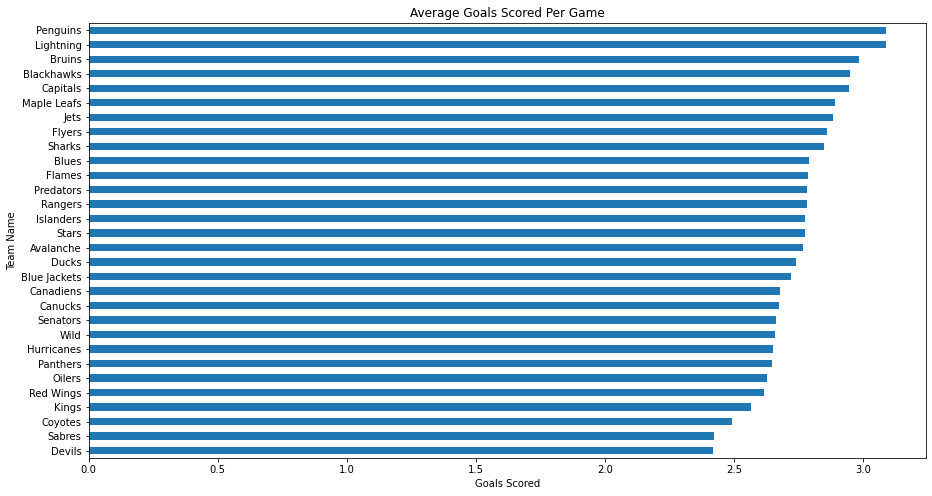

In [31]:
# Plotting average goals per game per team from 2010-2018
goals_for_average = new_game_df.groupby('teamName_cur')['goals_for'].mean().sort_values()
goals_for_average.plot(kind='barh', figsize=(15,8), title='Average Goals Scored Per Game')
plt.xlabel('Goals Scored')
plt.ylabel('Team Name')
plt.show()

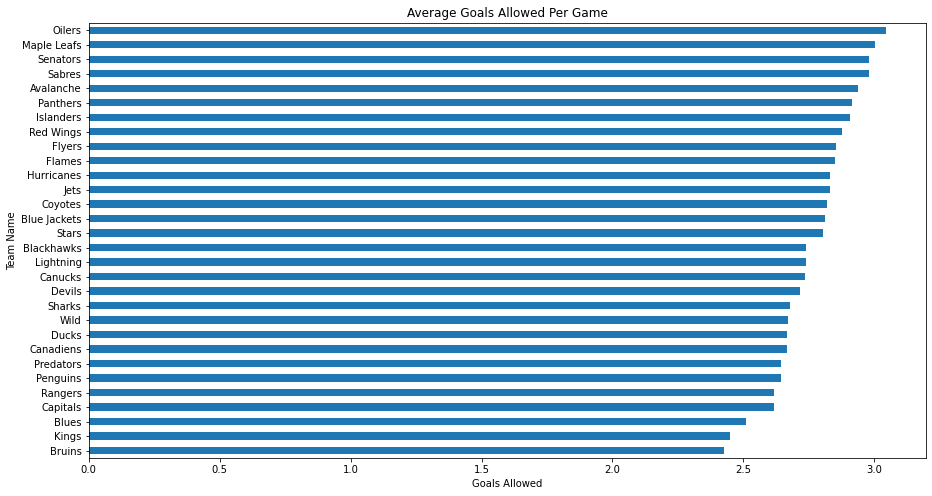

In [32]:
#Plotting goals allowed per team from 2010-2018
goals_against_average = new_game_df.groupby('teamName_cur')['goals_against'].mean().sort_values()
goals_against_average.plot(kind='barh', figsize=(15,8), title='Average Goals Allowed Per Game')
plt.xlabel('Goals Allowed')
plt.ylabel('Team Name')
plt.show()

### Finding out which types of goals are scored

In [33]:
#types of goals scored
game_plays_df[game_plays_df['event'] == 'Goal']['secondaryType'].unique()

array(['Wrap-around', 'Backhand', 'Slap Shot', 'Wrist Shot', 'Deflected',
       'Snap Shot', 'Tip-In', nan], dtype=object)

In [34]:
goal_type = game_plays_df[game_plays_df['event'] == 'Goal'].groupby('secondaryType')['event'].value_counts().sort_values()
goal_type_df = goal_type.to_frame()
goal_type_df.reset_index(level=[0], inplace = True)
goal_type_df

,secondaryType,event
event,,
Goal,Wrap-around,656
Goal,Deflected,2681
Goal,Tip-In,8014
Goal,Backhand,9523
Goal,Slap Shot,9835
Goal,Snap Shot,13096
Goal,Wrist Shot,45249


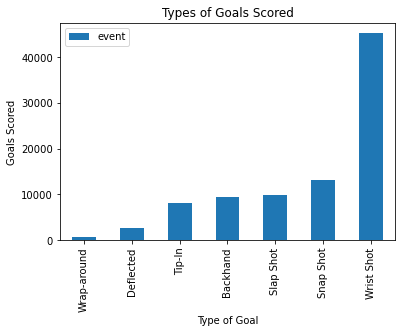

In [35]:
goal_type_df.plot(kind='bar', x = 'secondaryType', title ='Types of Goals Scored')
plt.xlabel('Type of Goal')
plt.ylabel('Goals Scored')
plt.show()

### Now to know which types of goals each team scored

In [36]:
goal_type_team = game_plays_df[game_plays_df['event'] == 'Goal'].groupby(['secondaryType','game_id','team_id_for'])['event'].value_counts()
goal_type_team_df = goal_type_team.to_frame()
goal_type_team_df.reset_index(level=[0,1,2], inplace = True)
goal_type_team_df.head()

,secondaryType,game_id,team_id_for,event
event,,,,
Goal,Backhand,2005020021,12.0,1
Goal,Backhand,2005020036,22.0,1
Goal,Backhand,2005020069,16.0,1
Goal,Backhand,2005020083,14.0,1
Goal,Backhand,2005020083,15.0,1


In [37]:
#add the team name and the year
goal_type_team_df = goal_type_team_df.merge(
    new_game_df[['teamName_cur','season','cur_team_id','game_id']],
    left_on = ['team_id_for','game_id'],
    right_on = ['cur_team_id','game_id']
    )

del goal_type_team_df['cur_team_id']

In [38]:
goal_type_team_df.head()

,secondaryType,game_id,team_id_for,event,teamName_cur,season
0,Backhand,2010020001,10.0,1,Maple Leafs,2010
1,Tip-In,2010020001,10.0,1,Maple Leafs,2010
2,Wrist Shot,2010020001,10.0,1,Maple Leafs,2010
3,Backhand,2010020003,12.0,1,Hurricanes,2010
4,Deflected,2010020003,12.0,1,Hurricanes,2010


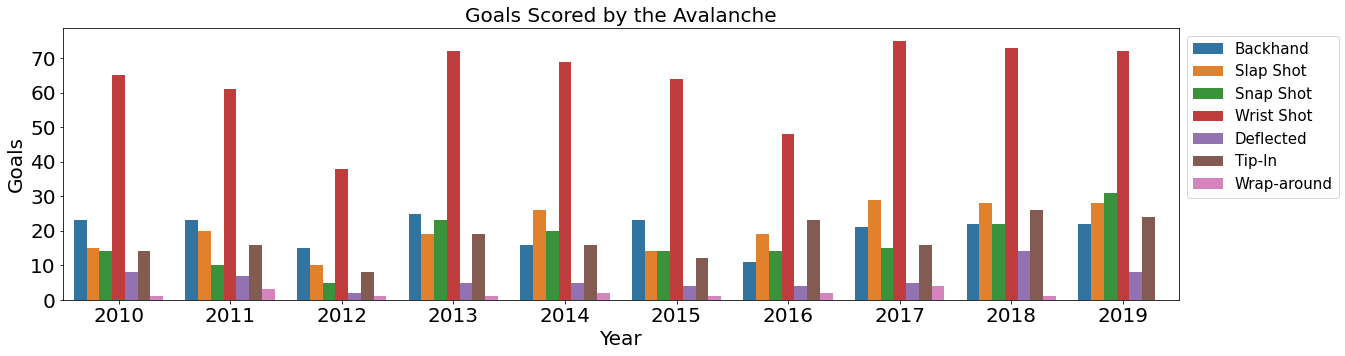

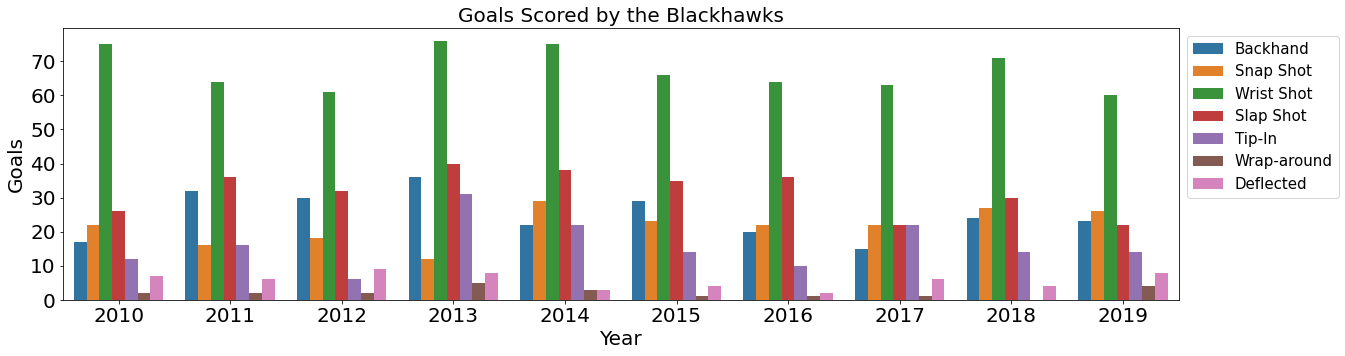

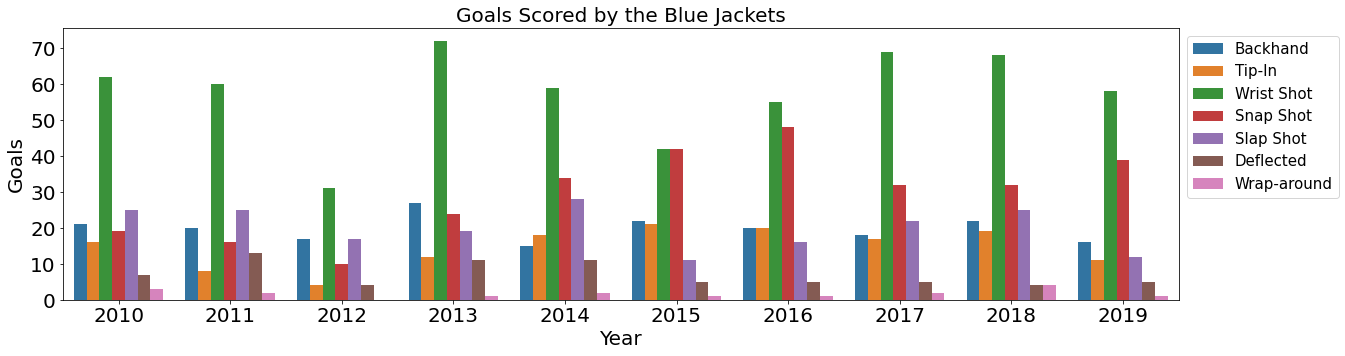

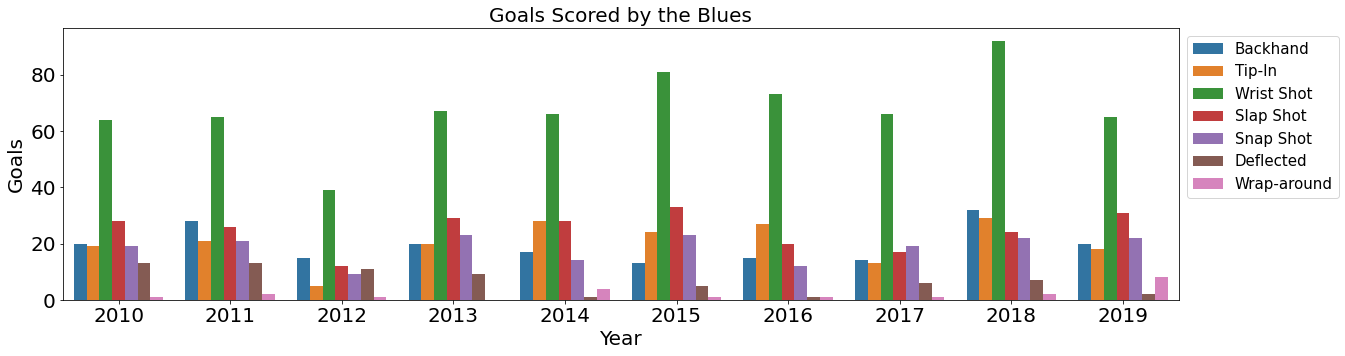

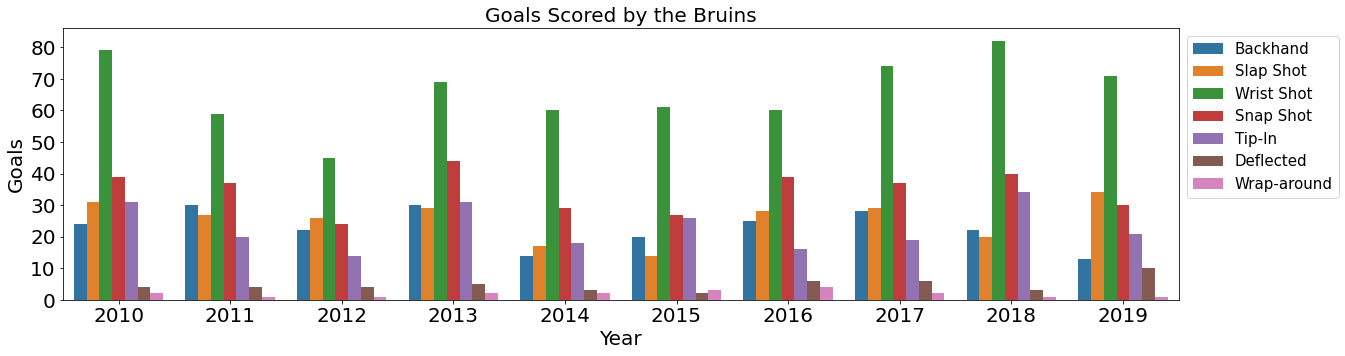

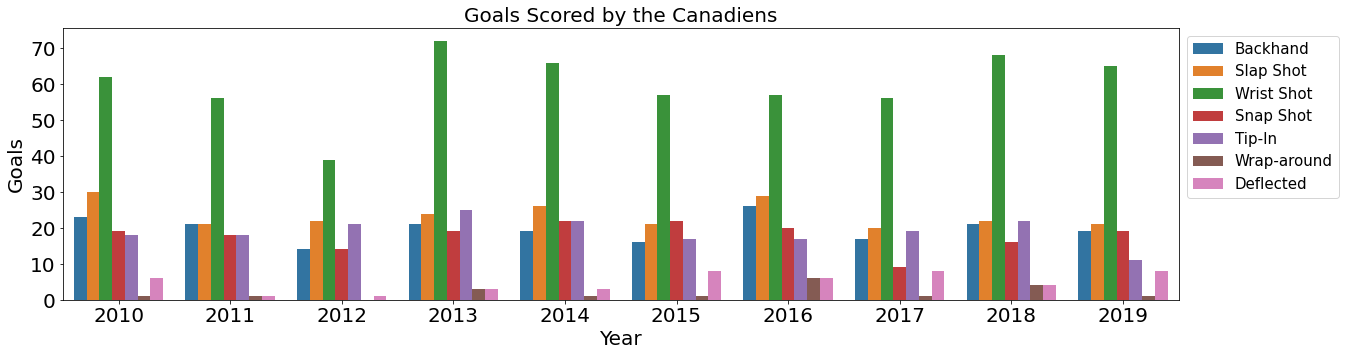

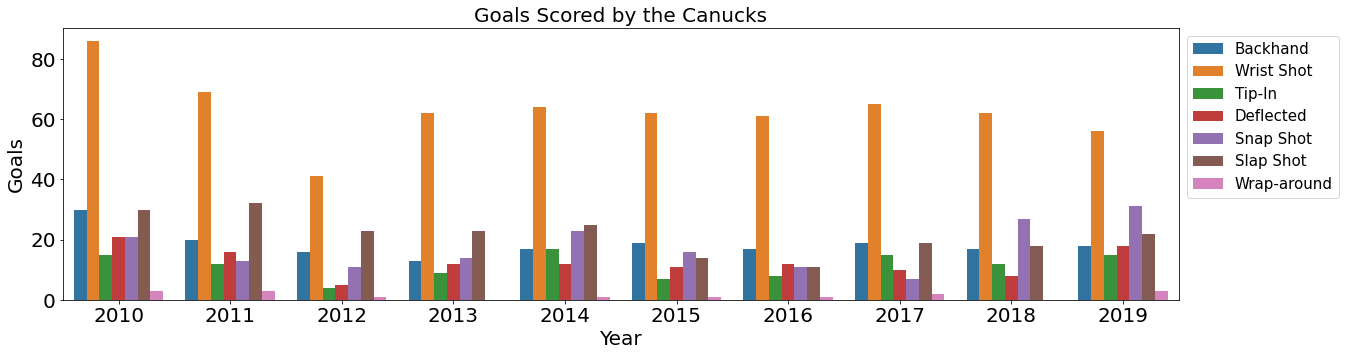

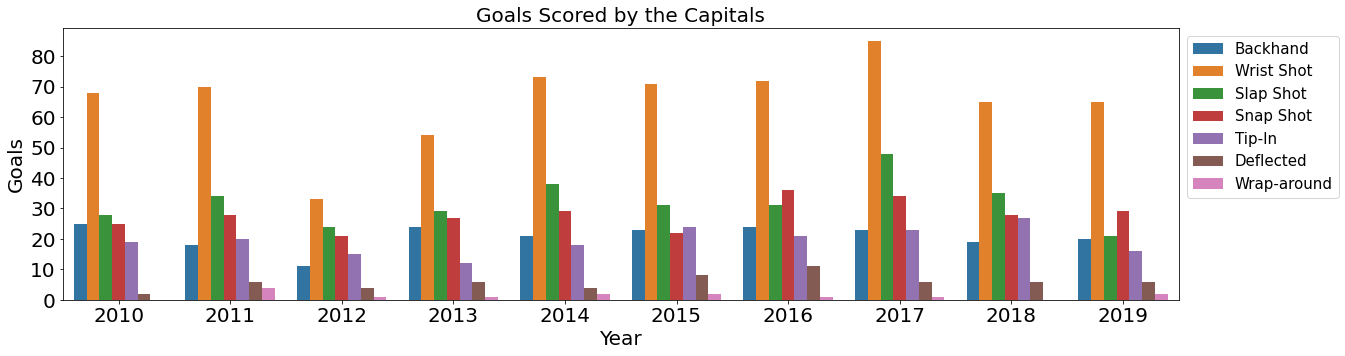

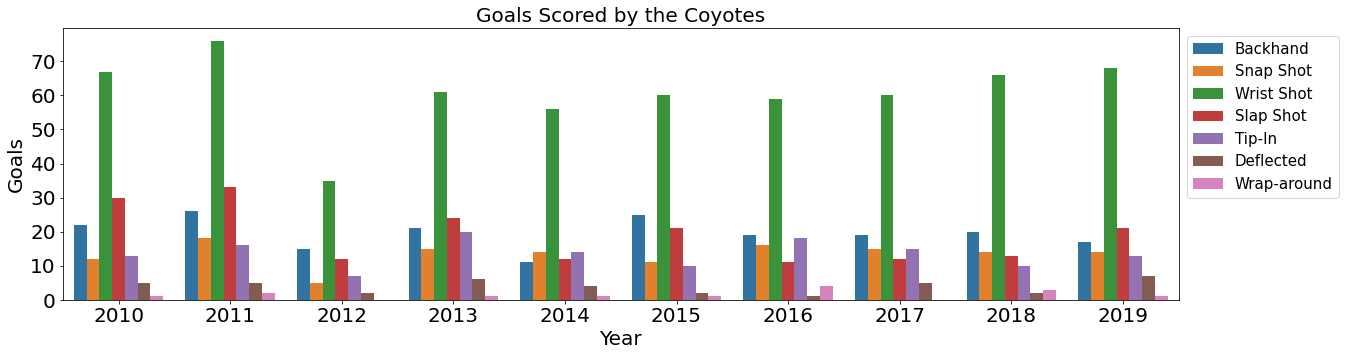

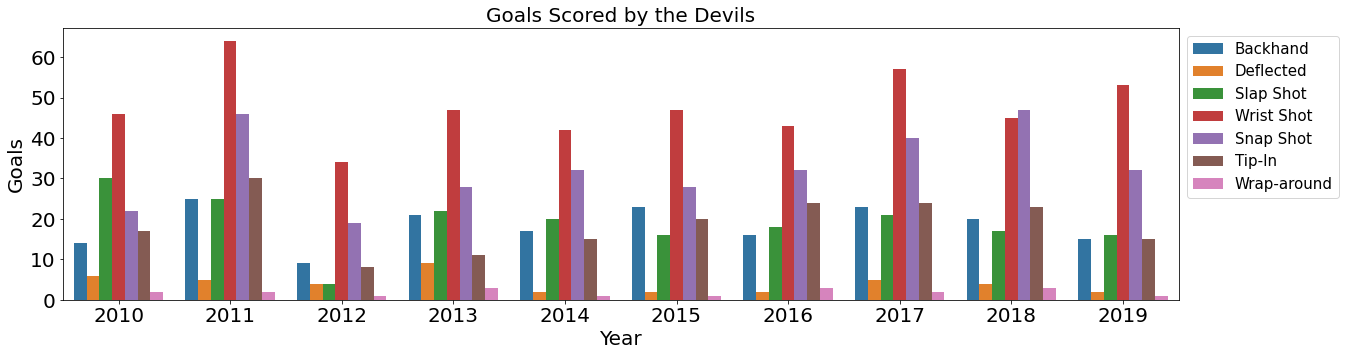

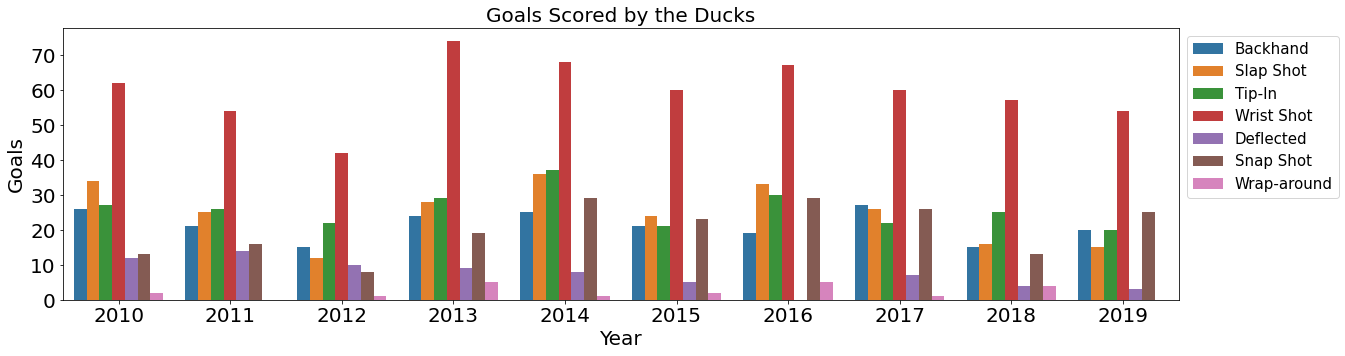

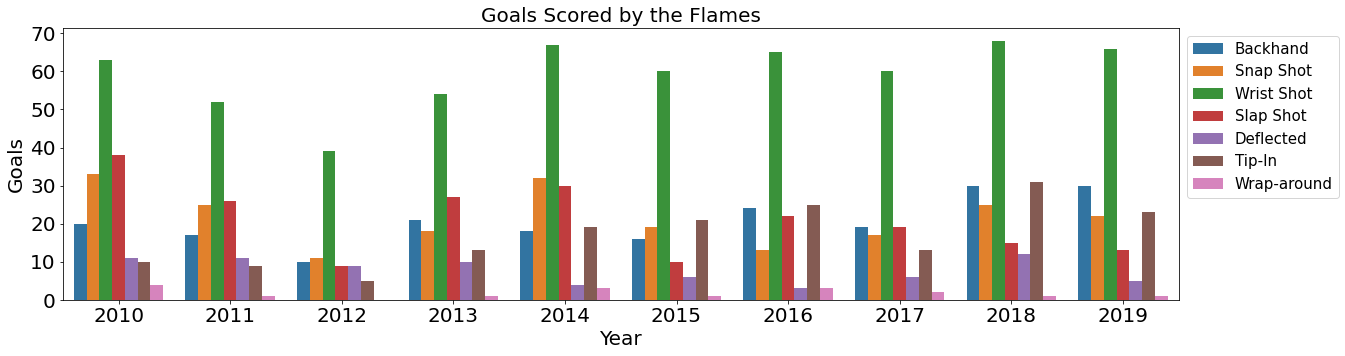

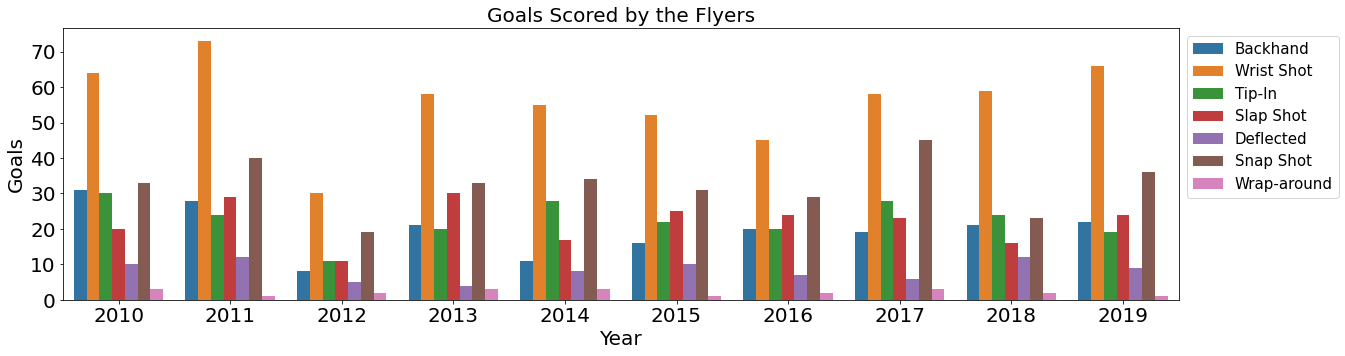

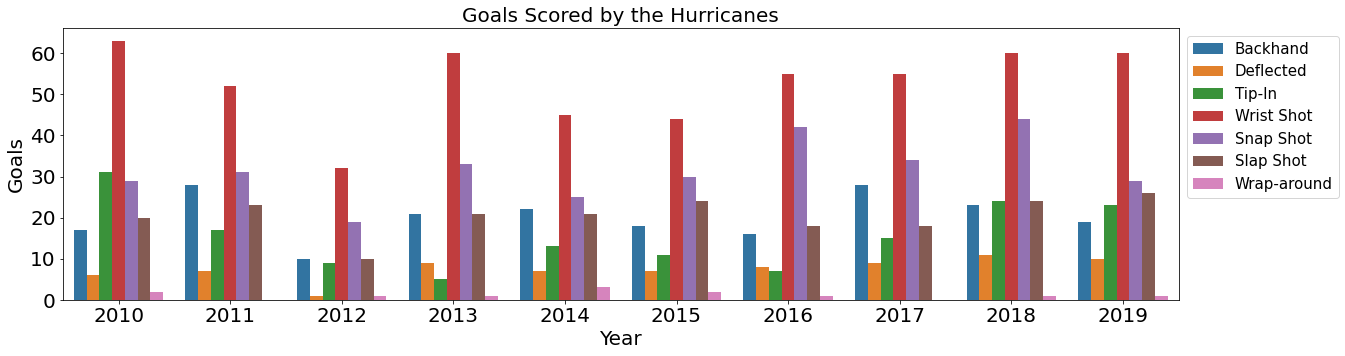

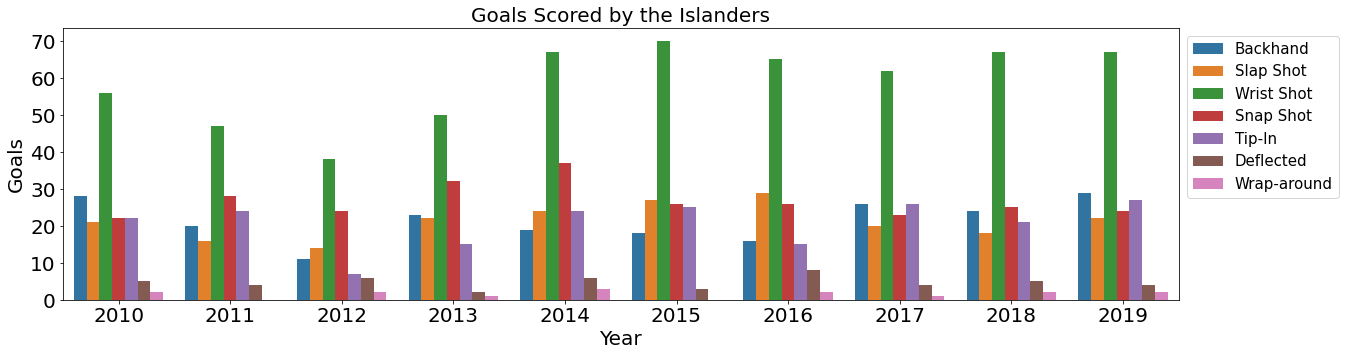

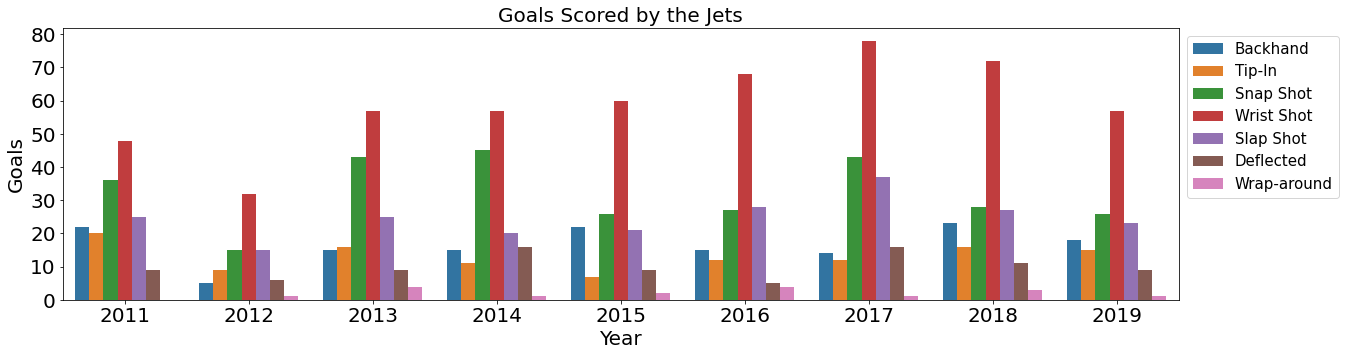

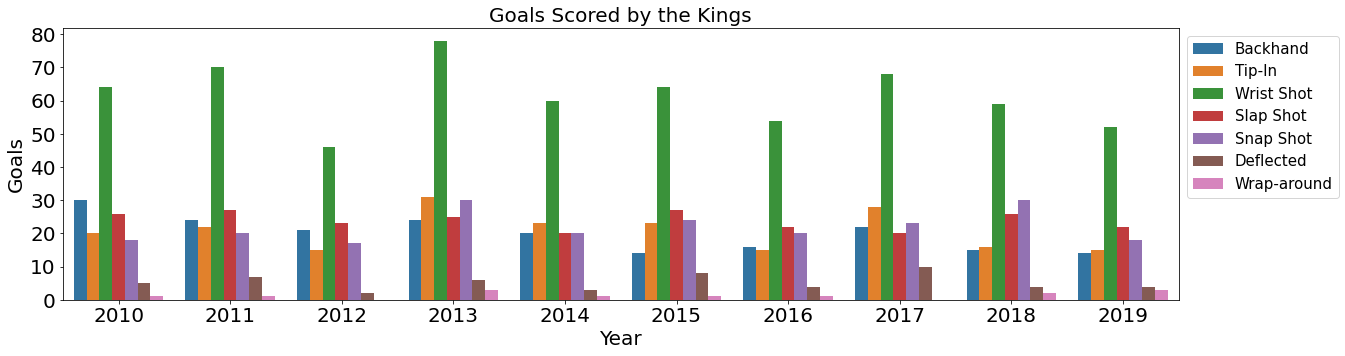

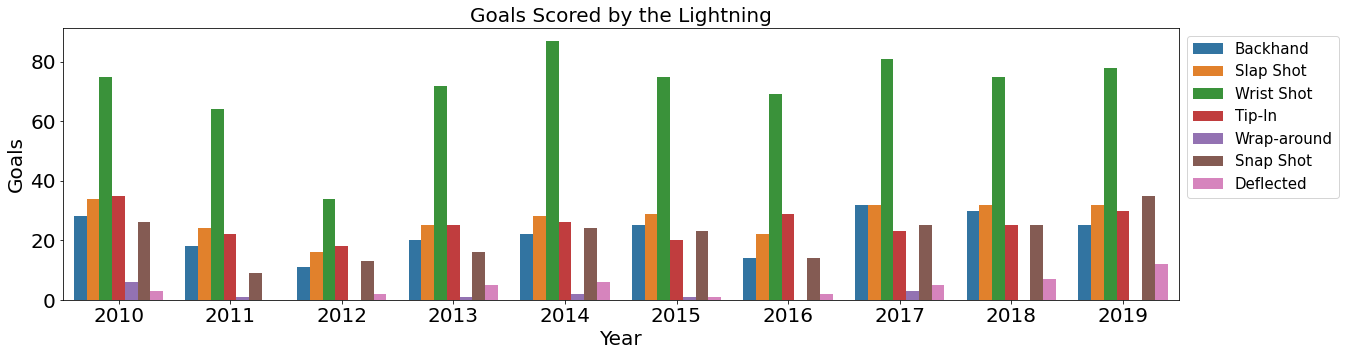

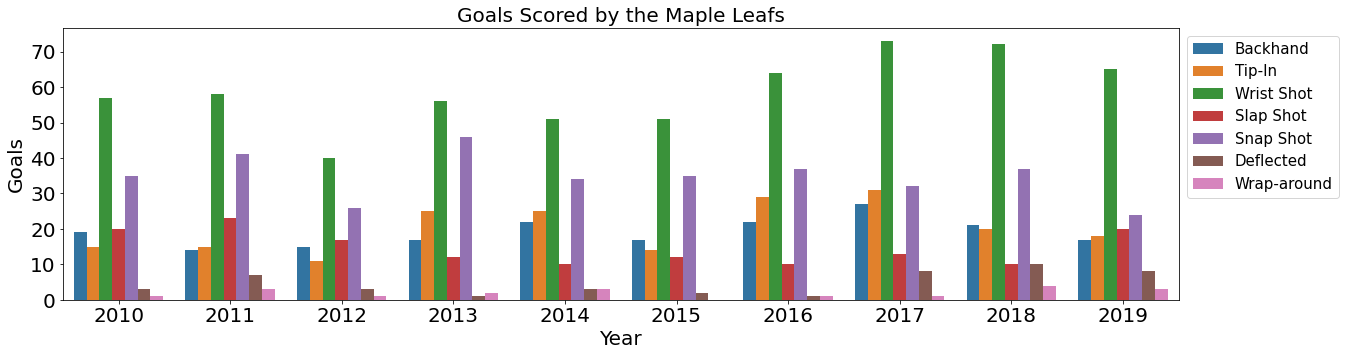

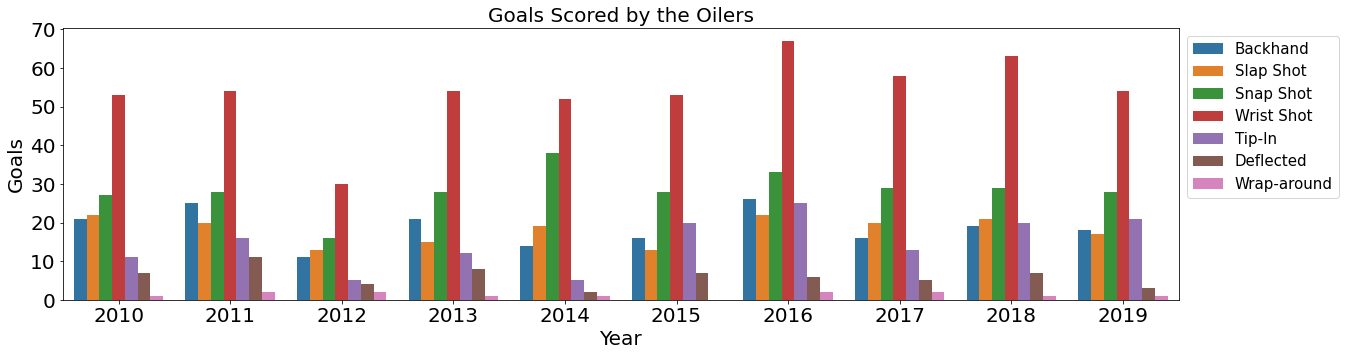

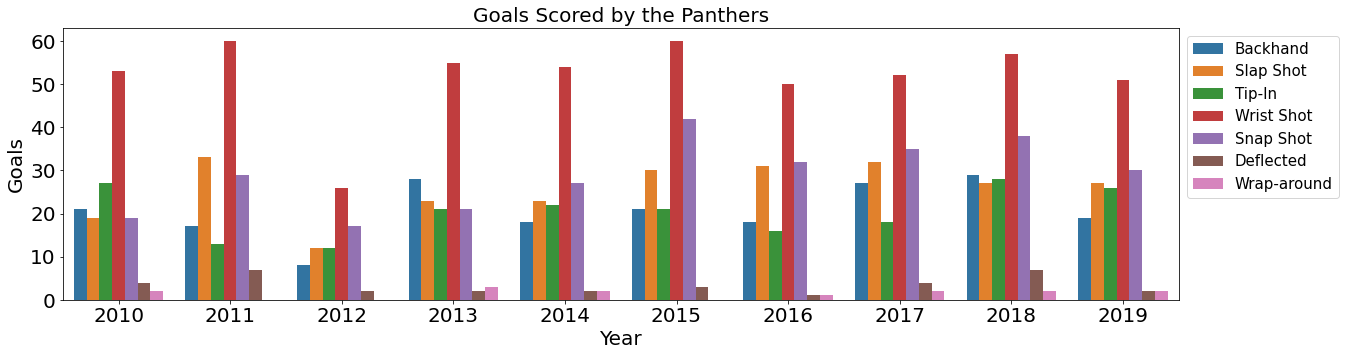

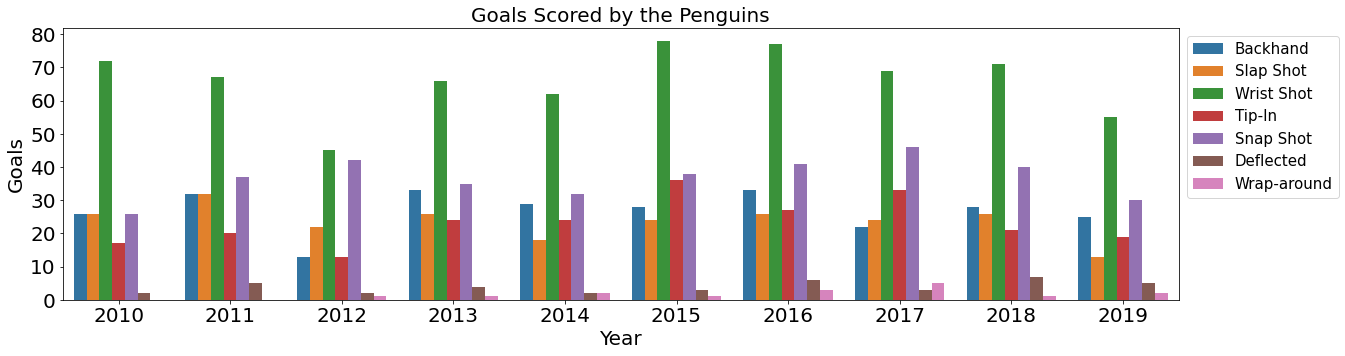

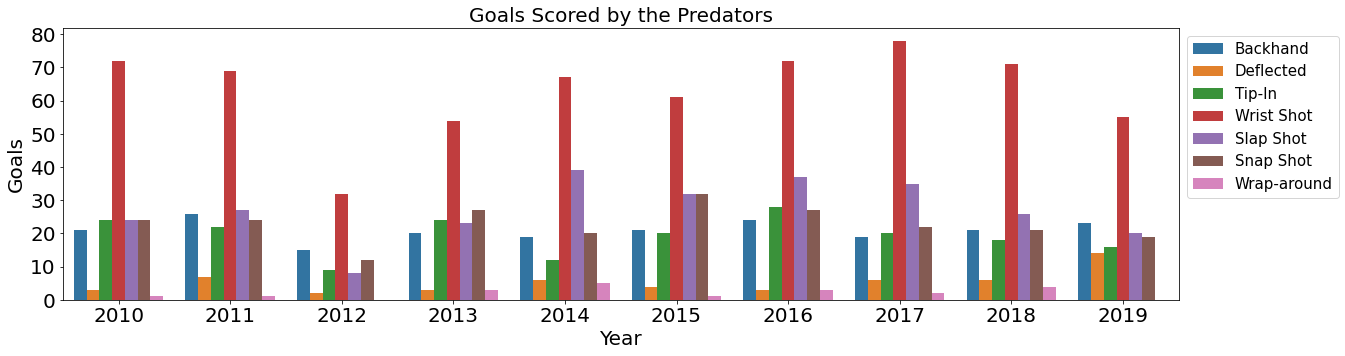

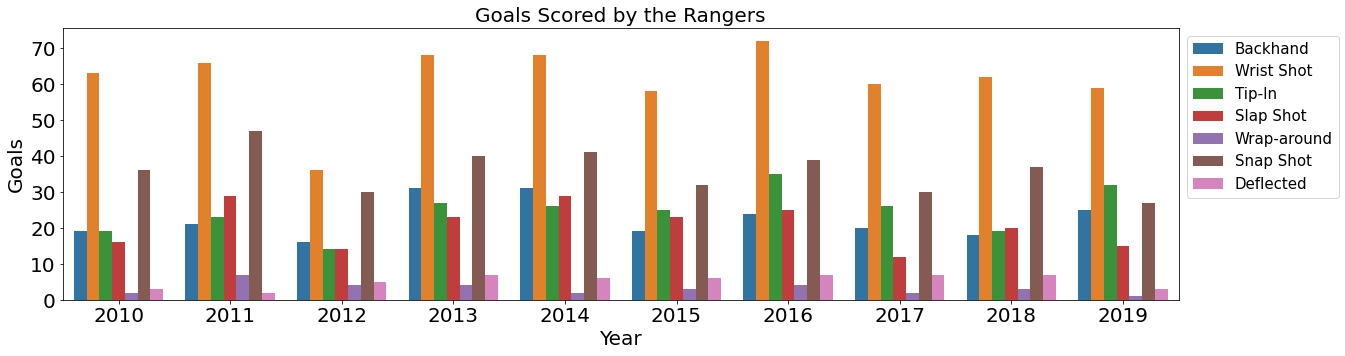

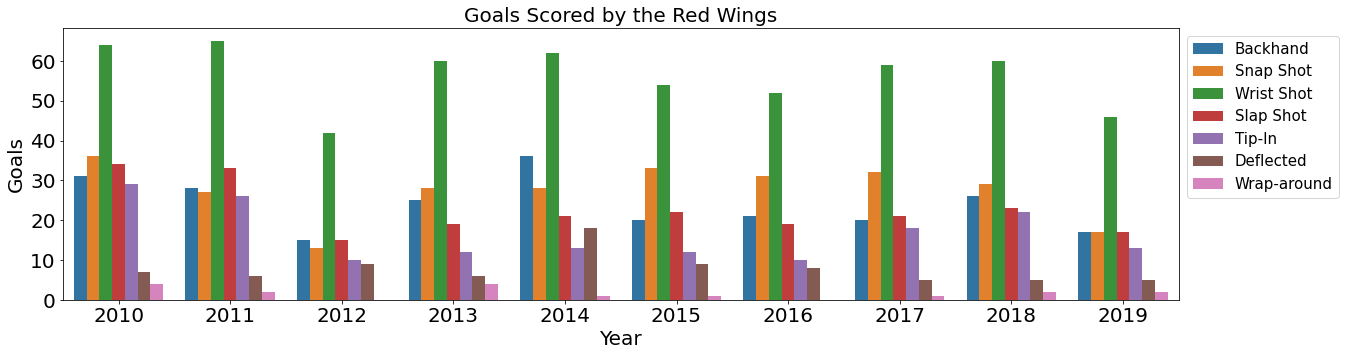

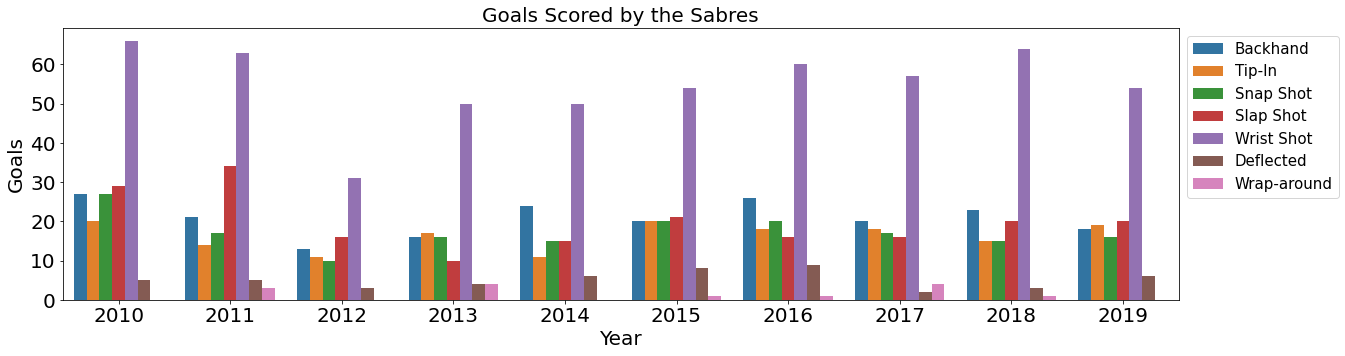

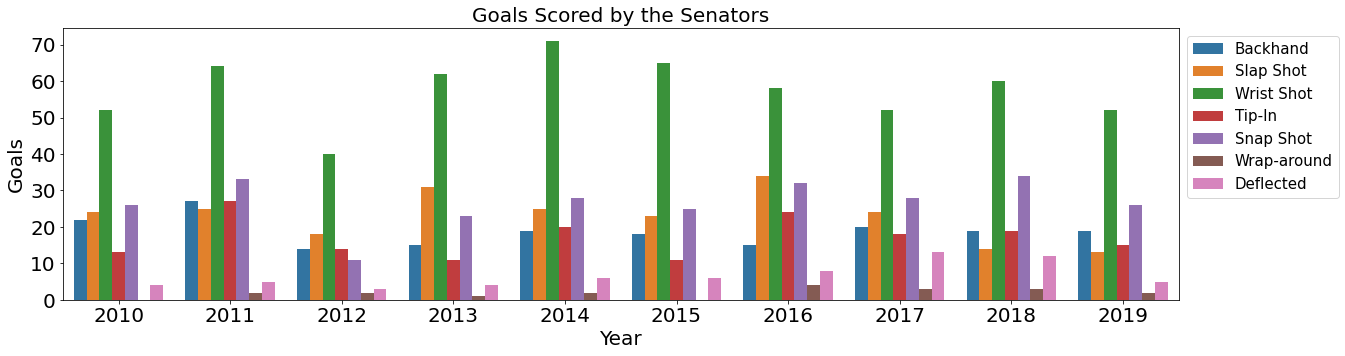

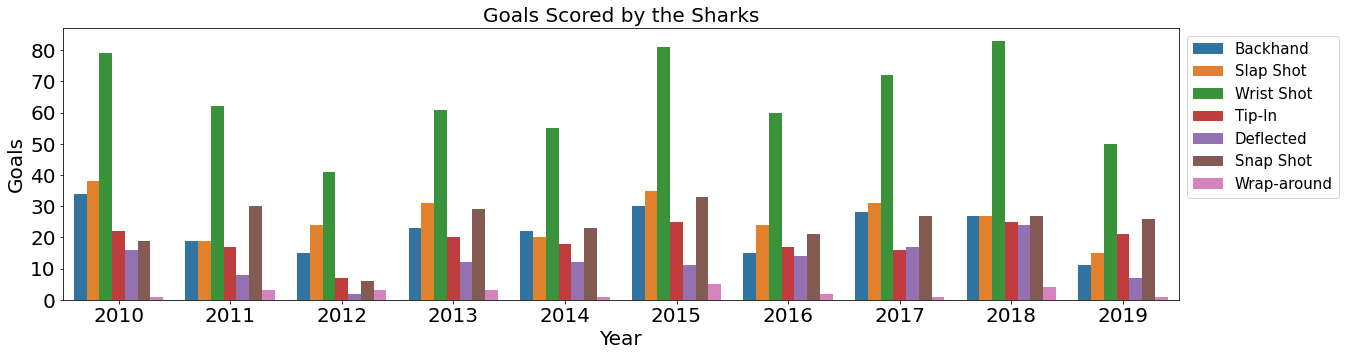

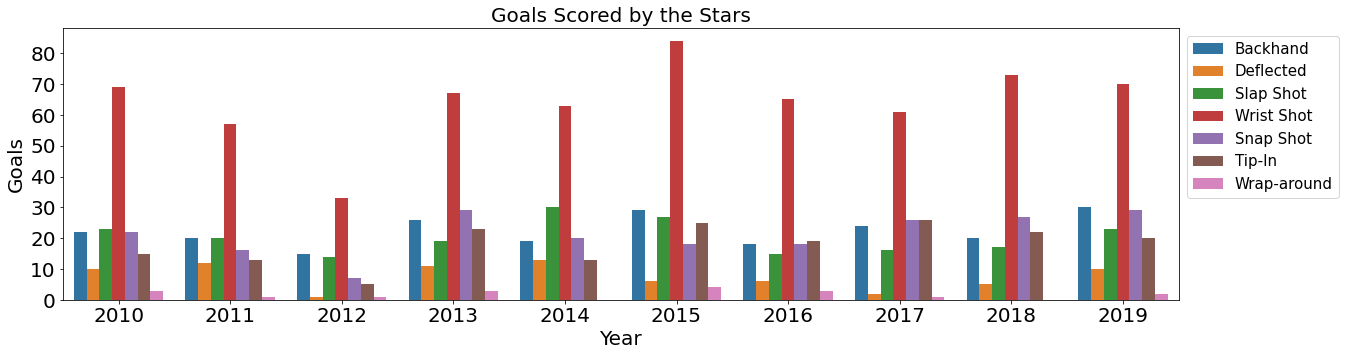

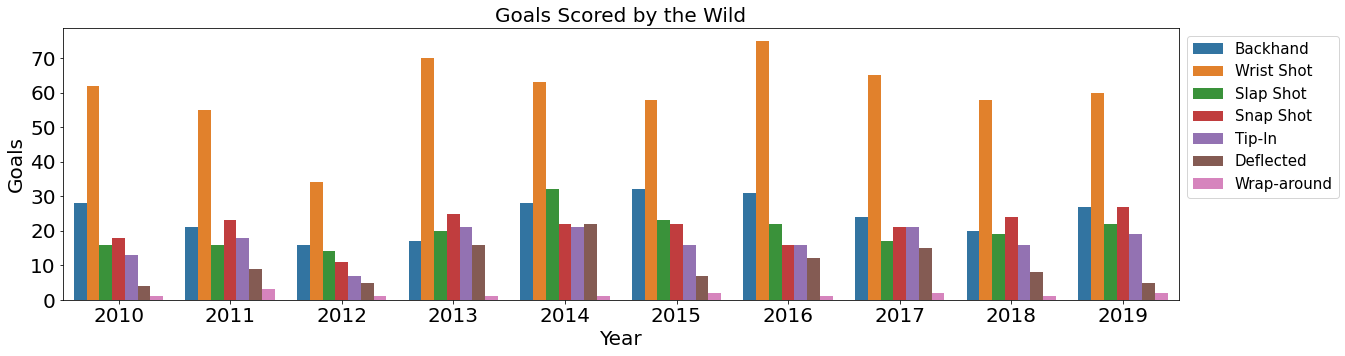

In [39]:
#Looking at which goals each team scored for each season
for team,data in goal_type_team_df.groupby('teamName_cur'):

    plt.figure(figsize = (20,5))
    graph = sns.countplot(x='season', hue = 'secondaryType', data=data)
    graph.set_title('Goals Scored by the {}'.format(team),fontsize=20)
    plt.xlabel('Year',fontsize=20)
    plt.ylabel('Goals',fontsize=20)
    plt.legend(loc = 'upper right', fontsize = 15, bbox_to_anchor = (1.15,1.0))
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()


In [40]:
temp = goal_type_team_df.groupby(['teamName_cur'])['secondaryType'].value_counts()
temp = temp.to_frame().reset_index([0])
temp.head()
#plt.show()

,teamName_cur,secondaryType
secondaryType,,
Wrist Shot,Avalanche,637
Slap Shot,Avalanche,208
Backhand,Avalanche,201
Tip-In,Avalanche,174
Snap Shot,Avalanche,168


### Now looking at blocked shots

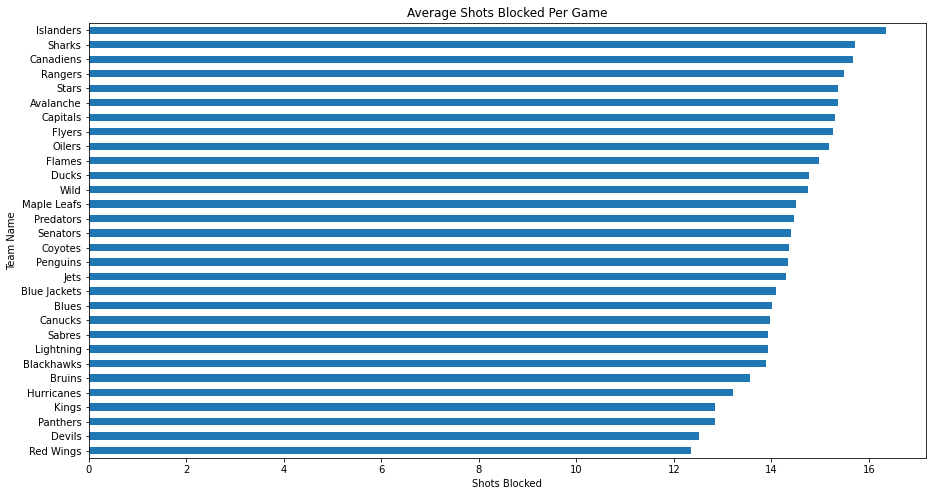

In [41]:
#Seeing which teams block the most shots per game from 2010-2018
blocked_for_average = new_game_df.groupby('teamName_cur')['blocked_for'].mean().sort_values()
blocked_for_average.plot(kind='barh', figsize=(15,8), title='Average Shots Blocked Per Game')
plt.xlabel('Shots Blocked')
plt.ylabel('Team Name')
plt.show()

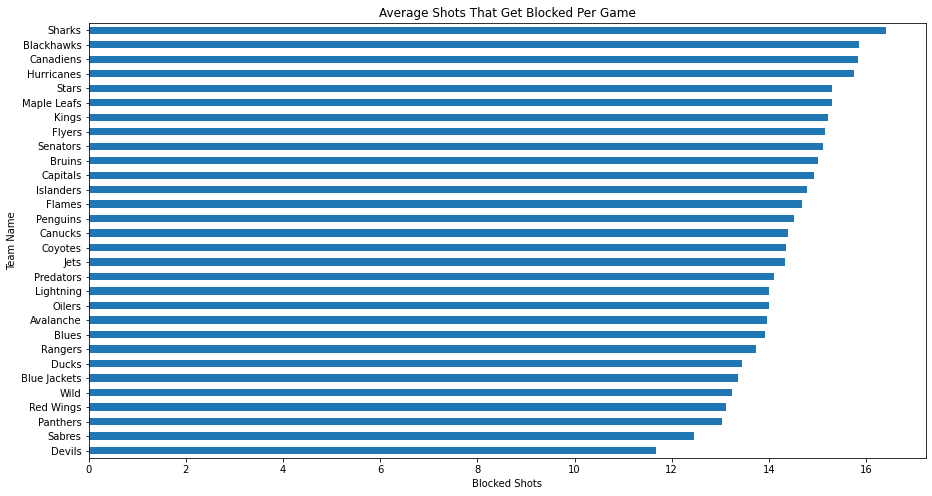

In [42]:
#Seeing which teams get their shots blocked the most during a game from 2010-2018
blocked_against_average = new_game_df.groupby('teamName_cur')['blocked_against'].mean().sort_values()
blocked_against_average.plot(kind='barh', figsize=(15,8), title='Average Shots That Get Blocked Per Game')
plt.xlabel('Blocked Shots')
plt.ylabel('Team Name')
plt.show()

## Now to look at shot attempts during a game.

In [43]:
new_game_df['shot_attempts'] = new_game_df['shots_for'] + new_game_df['blocked_against'] + new_game_df['missed_shots_for']

In [44]:
new_game_df.head()

,season,date_time_GMT,game_id,type,teamName_cur,teamName_opp,cur_team_id,opp_team_id,goals_for,goals_against,shots_for,shots_against,blocked_for,blocked_against,missed_shots_for,missed_shots_against,shot_attempts
0,2016,2016-10-19T00:30:00Z,2016020045,R,Blackhawks,Flyers,16,4,7.0,4.0,28.0,27.0,9.0,11.0,4,8,43.0
1,2016,2016-10-19T00:30:00Z,2016020045,R,Flyers,Blackhawks,4,16,4.0,7.0,27.0,28.0,11.0,9.0,8,4,44.0
2,2015,2015-10-15T00:00:00Z,2015020047,R,Blackhawks,Flyers,16,4,0.0,3.0,30.0,29.0,14.0,17.0,15,14,62.0
3,2015,2015-10-15T00:00:00Z,2015020047,R,Flyers,Blackhawks,4,16,3.0,0.0,29.0,30.0,17.0,14.0,14,15,57.0
4,2016,2016-12-03T18:00:00Z,2016020361,R,Blackhawks,Flyers,16,4,1.0,3.0,27.0,30.0,17.0,13.0,9,16,49.0


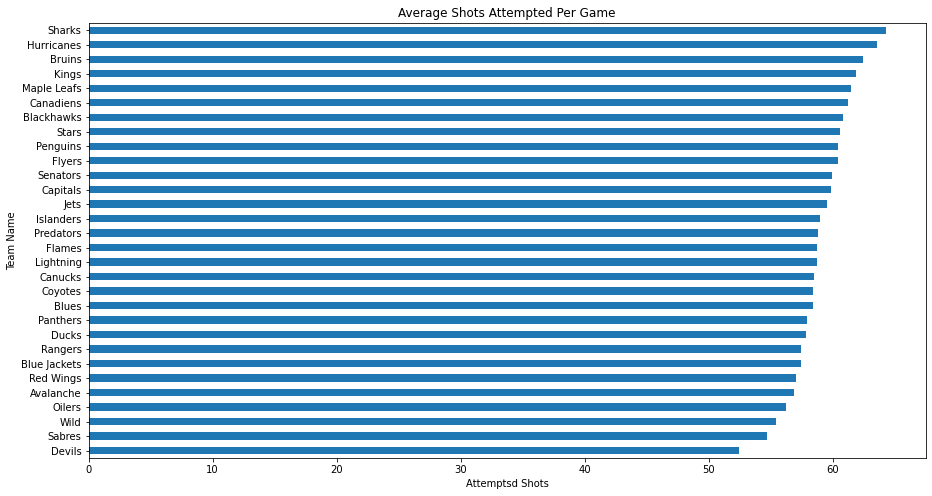

In [45]:
#looking at average shot attempts per game
average_shot_attempts = new_game_df.groupby('teamName_cur')['shot_attempts'].mean().sort_values()
average_shot_attempts.plot(kind='barh', figsize=(15,8), title='Average Shots Attempted Per Game')
plt.xlabel('Attemptsd Shots')
plt.ylabel('Team Name')
plt.show()

In [46]:
shot_attempt = new_game_df.groupby('teamName_cur')['shot_attempts'].sum().sort_values()
shot_attempt

teamName_cur
Devils          41150.0
Sabres          41824.0
Jets            42484.0
Oilers          43643.0
Wild            44725.0
Panthers        44756.0
Avalanche       45588.0
Blue Jackets    45613.0
Red Wings       45978.0
Coyotes         46145.0
Flames          46254.0
Islanders       47509.0
Canucks         47599.0
Ducks           47890.0
Senators        48106.0
Maple Leafs     48563.0
Stars           49242.0
Flyers          49298.0
Rangers         49478.0
Canadiens       49749.0
Predators       49804.0
Blues           49812.0
Hurricanes      49960.0
Lightning       50710.0
Capitals        51880.0
Kings           52070.0
Blackhawks      52084.0
Penguins        53014.0
Bruins          55096.0
Sharks          55547.0
Name: shot_attempts, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

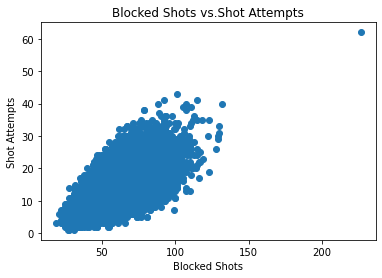

In [47]:
#Looking at correlation between blocked shots and shot attempts

plt.scatter(x = new_game_df['shot_attempts'], y = new_game_df['blocked_against'])
plt.title('Blocked Shots vs.Shot Attempts')
plt.xlabel('Blocked Shots')
plt.ylabel('Shot Attempts')
plt.show

<AxesSubplot:xlabel='blocked_against', ylabel='shot_attempts'>

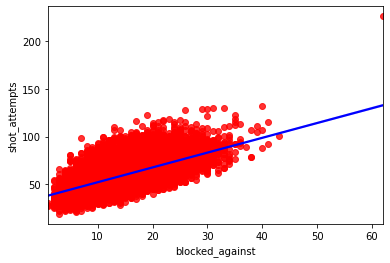

In [48]:
#plotting this correlation using a regression plot
sns.regplot(x = 'blocked_against', y = 'shot_attempts', data = new_game_df, scatter_kws = {'color': 'red'}, line_kws = {'color':'blue'})

In [50]:
#looking at correlation
new_game_df.corr()

,season,game_id,cur_team_id,opp_team_id,goals_for,goals_against,shots_for,shots_against,blocked_for,blocked_against,missed_shots_for,missed_shots_against,shot_attempts
season,1.000000,1.000000,0.050909,0.086034,0.058603,0.063218,0.075863,0.085878,0.003782,-0.004040,0.461768,0.465811,0.289131
game_id,1.000000,1.000000,0.050885,0.086018,0.058588,0.063205,0.075880,0.085898,0.003881,-0.003942,0.461795,0.465841,0.289192
cur_team_id,0.050909,0.050885,1.000000,0.152566,-0.013308,0.004315,-0.026006,-0.002035,0.005082,0.008733,0.035714,0.042524,0.009281
opp_team_id,0.086034,0.086018,0.152566,1.000000,0.003164,-0.003637,-0.008488,-0.007599,0.021592,0.002628,0.055135,0.067965,0.026595
goals_for,0.058603,0.058588,-0.013308,0.003164,1.000000,-0.051762,0.130117,0.067338,0.107730,-0.176509,-0.029524,0.067132,-0.016857
goals_against,0.063218,0.063205,0.004315,-0.003637,-0.051762,1.000000,0.068814,0.130351,-0.173634,0.110541,0.070172,-0.027517,0.116922
shots_for,0.075863,0.075880,-0.026006,-0.008488,0.130117,0.068814,1.000000,-0.109841,-0.129589,0.232441,0.205264,-0.069573,0.722535
shots_against,0.085878,0.085898,-0.002035,-0.007599,0.067338,0.130351,-0.109841,1.000000,0.235324,-0.127631,-0.061473,0.211388,-0.140184
blocked_for,0.003782,0.003881,0.005082,0.021592,0.107730,-0.173634,-0.129589,0.235324,1.000000,-0.033847,-0.083068,0.174772,-0.125798
blocked_against,-0.004040,-0.003942,0.008733,0.002628,-0.176509,0.110541,0.232441,-0.127631,-0.033847,1.000000,0.170445,-0.084214,0.602023


Text(113.7, 0.5, 'Stat Features')

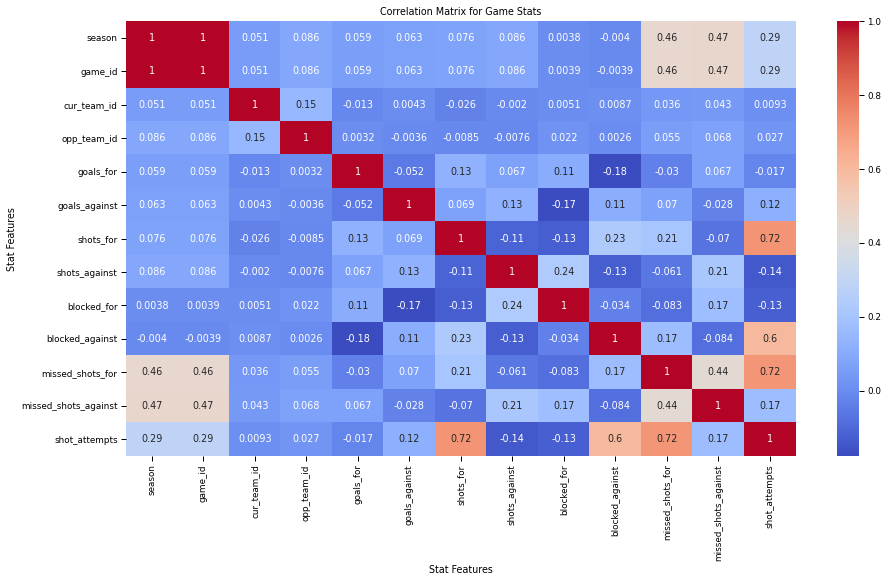

In [51]:
sns.set_context('paper',font_scale=1)
plt.figure(figsize = (15,8))
sns.heatmap(new_game_df.corr('pearson'), annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix for Game Stats')
plt.xlabel('Stat Features')
plt.ylabel('Stat Features')

## Building Corsi/Fenwick Dataframes

Gathering all of the collected data and placing them for each team in one place

In [52]:
#adding total shots, blocked shots, missed shots per season
adv_stats_df = new_game_df.groupby(['season','teamName_cur'])['goals_for','goals_against','shot_attempts','shots_for','blocked_for','missed_shots_for','shots_against','blocked_against','missed_shots_against'].sum().reset_index()

<ipython-input-52-b881cbd676d7>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  adv_stats_df = new_game_df.groupby(['season','teamName_cur'])['goals_for','goals_against','shot_attempts','shots_for','blocked_for','missed_shots_for','shots_against','blocked_against','missed_shots_against'].sum().reset_index()


In [53]:
#QA
adv_stats_df.head()

,season,teamName_cur,goals_for,goals_against,shot_attempts,shots_for,blocked_for,missed_shots_for,shots_against,blocked_against,missed_shots_against
0,2010,Avalanche,213.0,280.0,4100.0,2289.0,1130.0,827,2517.0,984.0,1009
1,2010,Blackhawks,259.0,228.0,4874.0,2713.0,1205.0,963,2463.0,1198.0,888
2,2010,Blue Jackets,208.0,249.0,4566.0,2481.0,1102.0,946,2418.0,1139.0,868
3,2010,Blues,222.0,221.0,4461.0,2369.0,1030.0,999,2162.0,1093.0,874
4,2010,Bruins,321.0,237.0,6386.0,3474.0,1538.0,1233,3508.0,1679.0,1188


In [54]:
#calculating corsi for and against

adv_stats_df['corsi_for'] = adv_stats_df['shots_for'] + adv_stats_df['blocked_for'] + adv_stats_df['missed_shots_for']
adv_stats_df['fenwick_for'] = adv_stats_df['shots_for'] + adv_stats_df['missed_shots_for']
adv_stats_df['corsi_against'] = adv_stats_df['shots_against'] + adv_stats_df['blocked_against'] + adv_stats_df['missed_shots_against']
adv_stats_df['fenwick_against'] = adv_stats_df['shots_against'] + adv_stats_df['missed_shots_against']

In [55]:
#calculating corsi percentage

adv_stats_df['corsi_percentage'] = (adv_stats_df['corsi_for'] / (adv_stats_df['corsi_for'] + adv_stats_df['corsi_against'])) * 100
adv_stats_df['fenwick_percentage'] = (adv_stats_df['fenwick_for'] / (adv_stats_df['fenwick_for'] + adv_stats_df['fenwick_against'])) * 100

In [56]:
#QA
adv_stats_df.head()

,season,teamName_cur,goals_for,goals_against,shot_attempts,shots_for,blocked_for,missed_shots_for,shots_against,blocked_against,missed_shots_against,corsi_for,fenwick_for,corsi_against,fenwick_against,corsi_percentage,fenwick_percentage
0,2010,Avalanche,213.0,280.0,4100.0,2289.0,1130.0,827,2517.0,984.0,1009,4246.0,3116.0,4510.0,3526.0,48.492462,46.913580
1,2010,Blackhawks,259.0,228.0,4874.0,2713.0,1205.0,963,2463.0,1198.0,888,4881.0,3676.0,4549.0,3351.0,51.760339,52.312509
2,2010,Blue Jackets,208.0,249.0,4566.0,2481.0,1102.0,946,2418.0,1139.0,868,4529.0,3427.0,4425.0,3286.0,50.580746,51.050201
3,2010,Blues,222.0,221.0,4461.0,2369.0,1030.0,999,2162.0,1093.0,874,4398.0,3368.0,4129.0,3036.0,51.577343,52.592130
4,2010,Bruins,321.0,237.0,6386.0,3474.0,1538.0,1233,3508.0,1679.0,1188,6245.0,4707.0,6375.0,4696.0,49.484945,50.058492


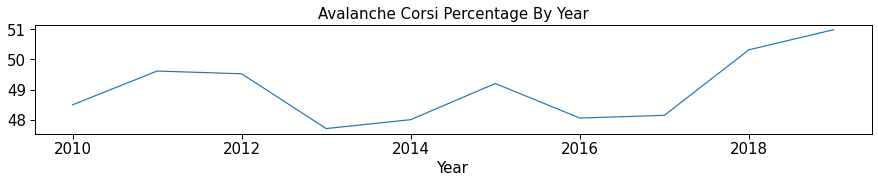

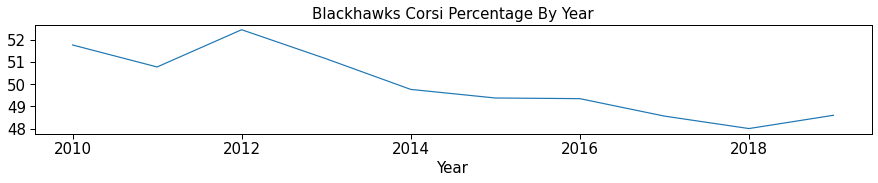

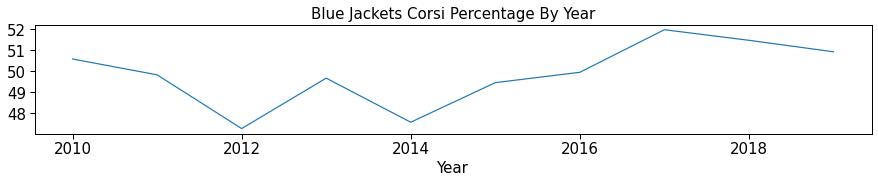

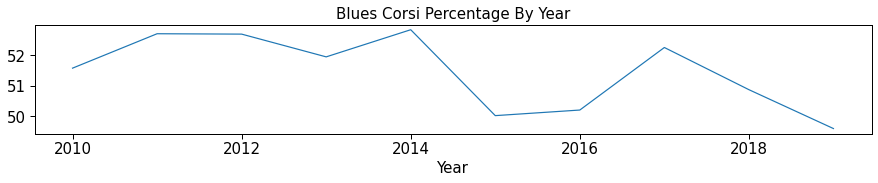

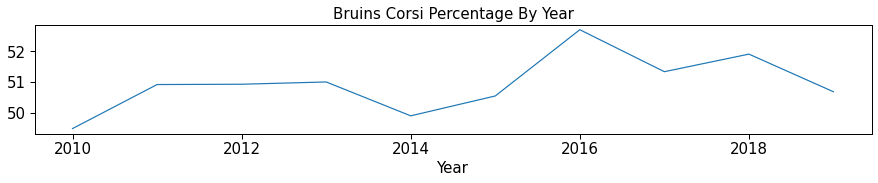

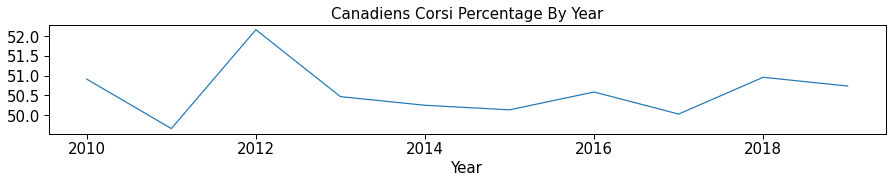

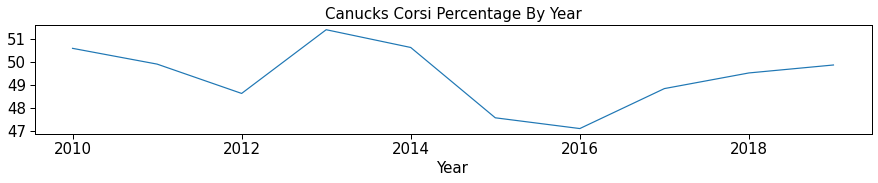

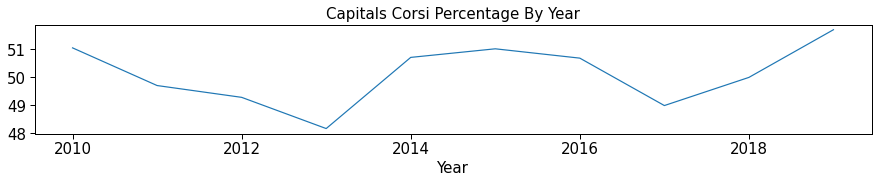

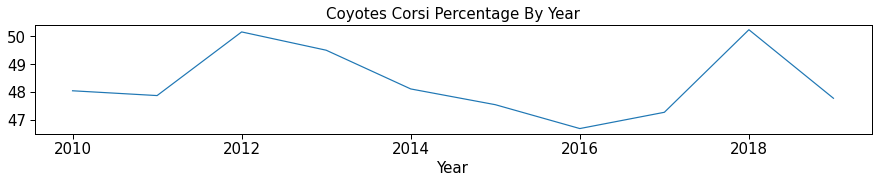

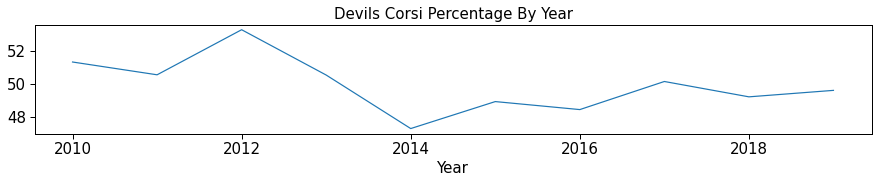

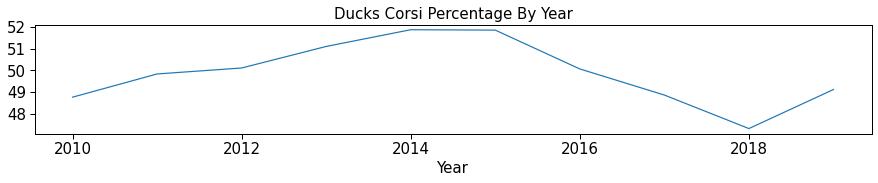

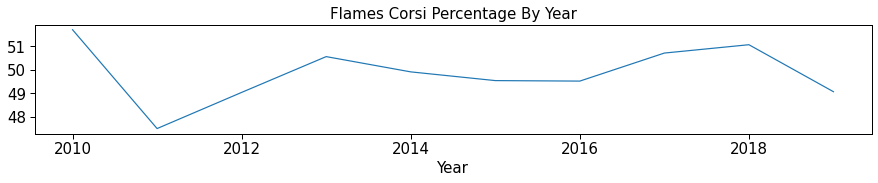

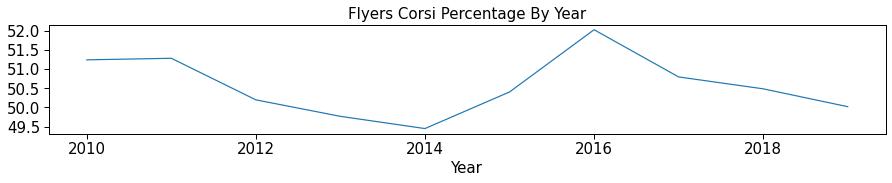

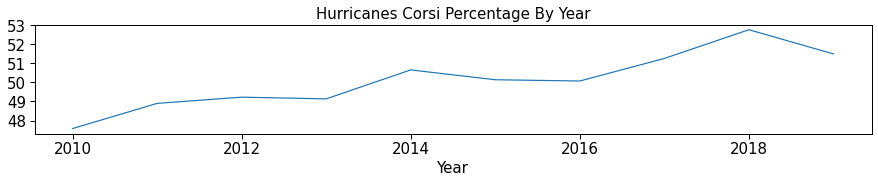

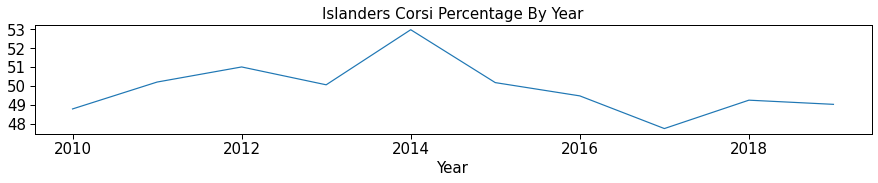

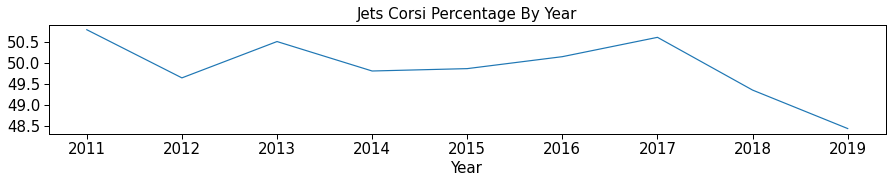

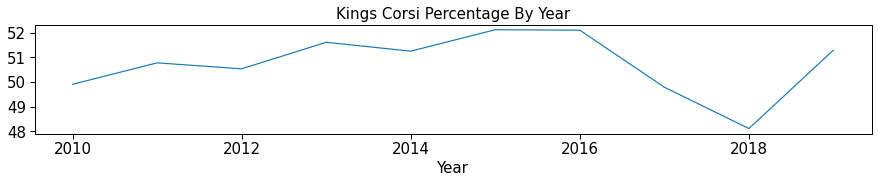

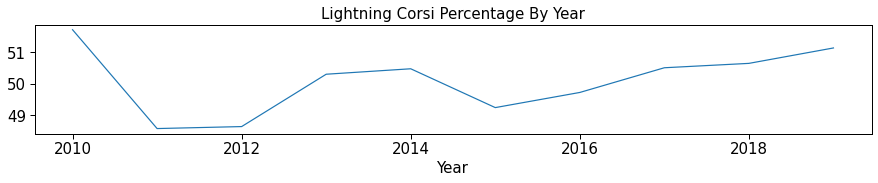

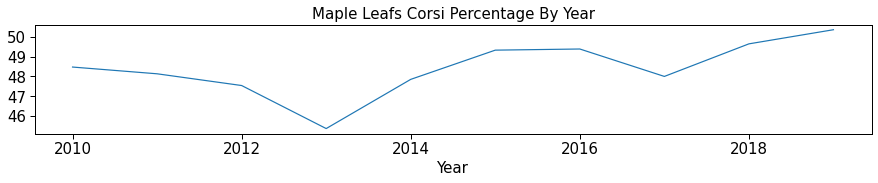

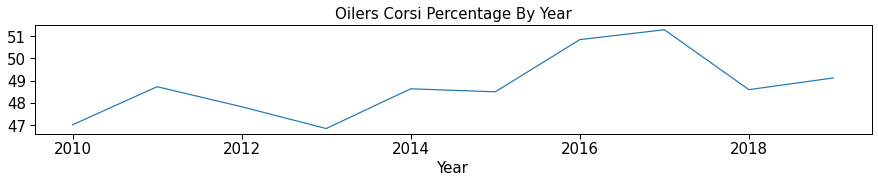

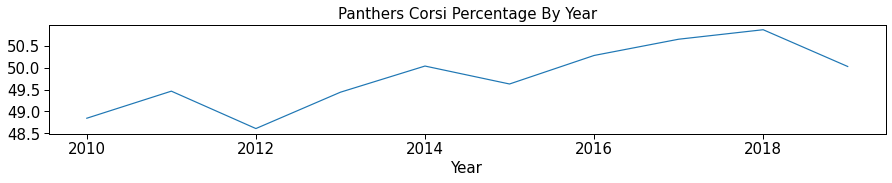

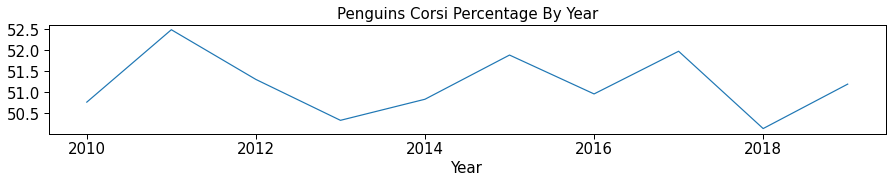

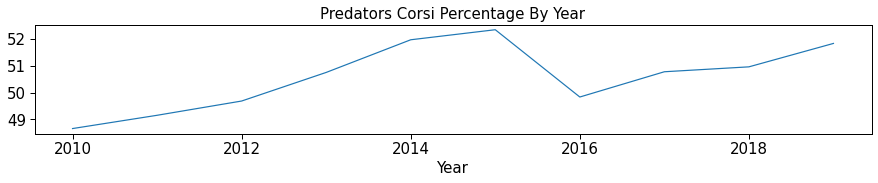

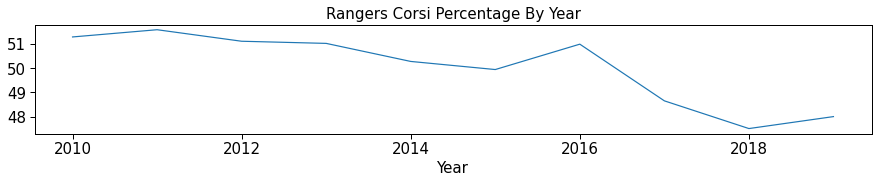

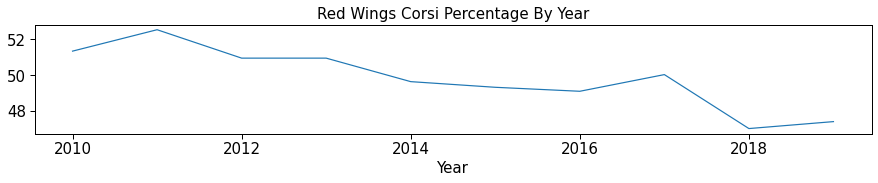

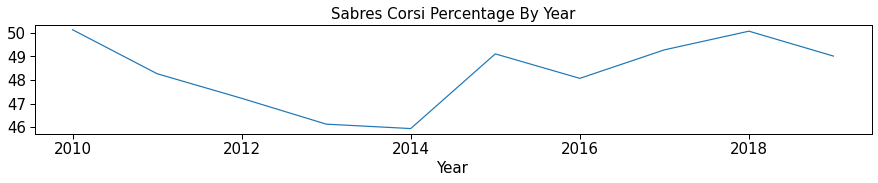

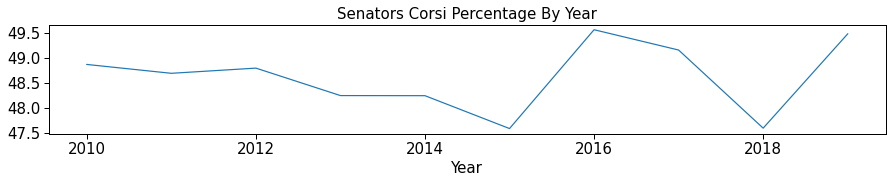

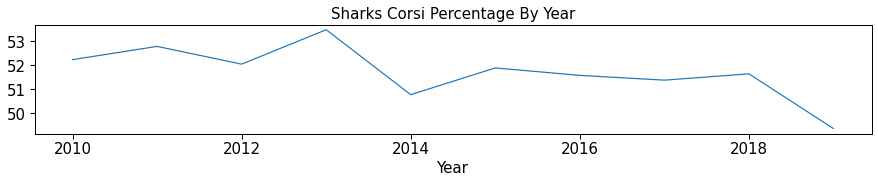

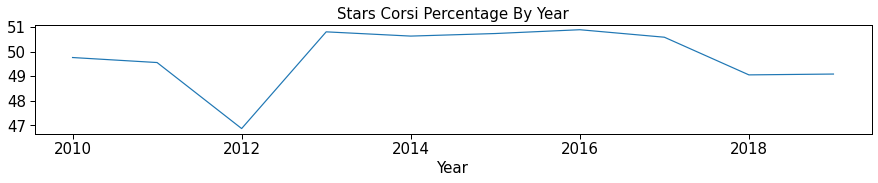

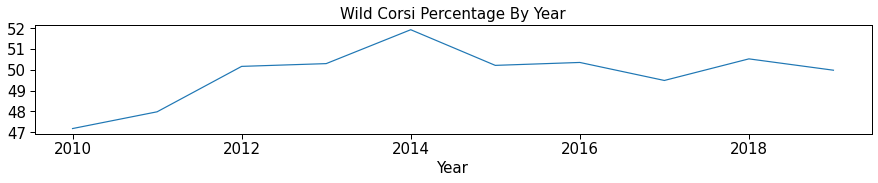

In [57]:
#NHL teams's corsi percentage from 2010-2019

for team,data in adv_stats_df.groupby('teamName_cur'):
    data.set_index('season')['corsi_percentage'].plot(x='season', kind='line', figsize=(15,2))
    plt.title('{} Corsi Percentage By Year'.format(team),fontsize=(15))
    plt.xlabel('Year',fontsize=15)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.show()

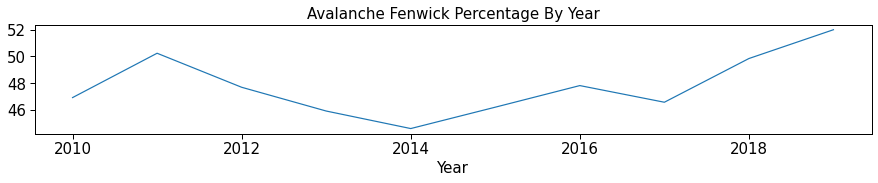

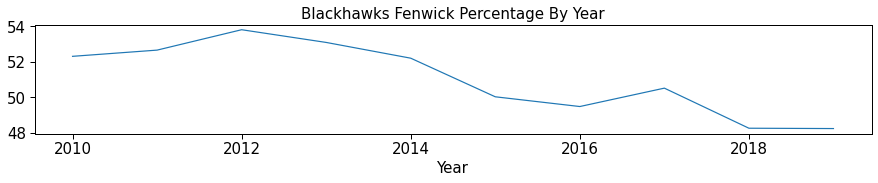

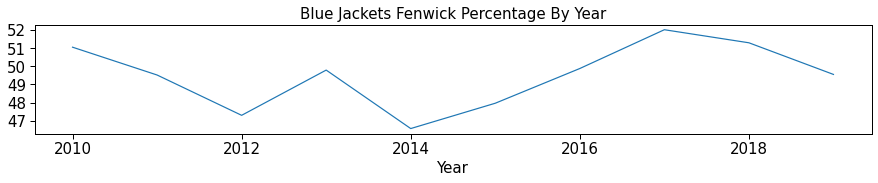

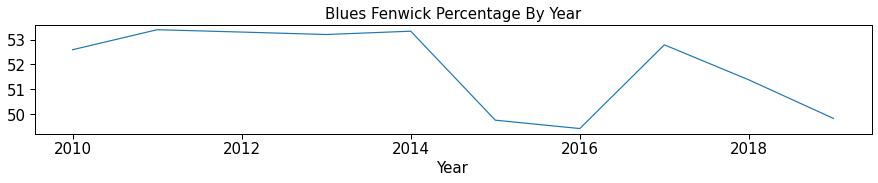

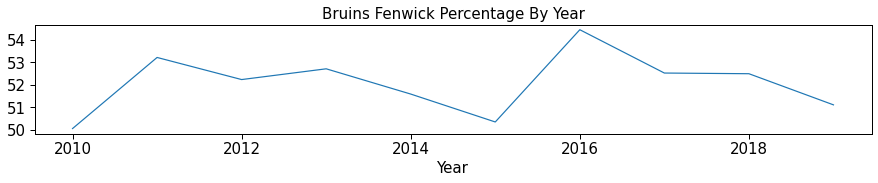

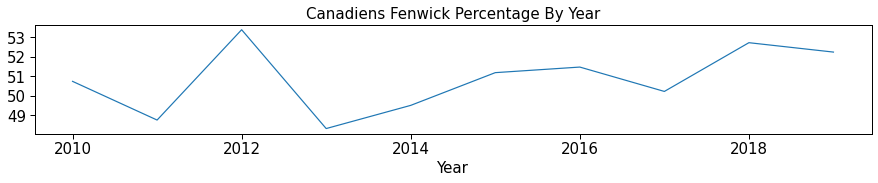

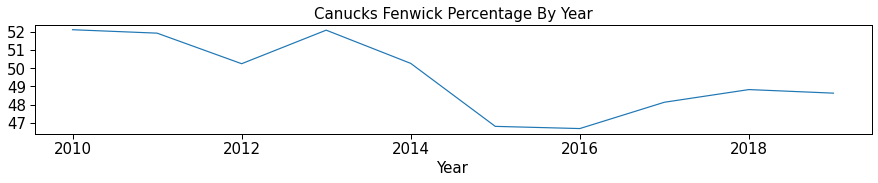

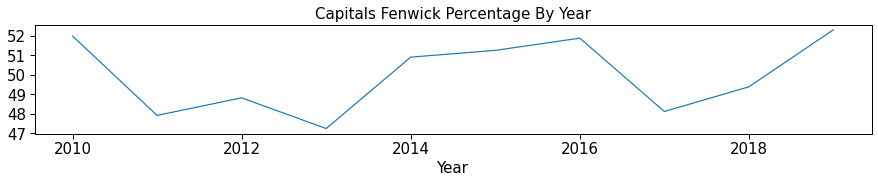

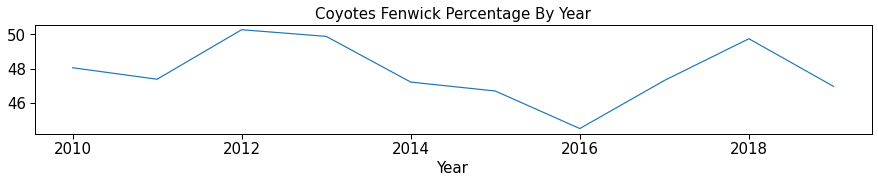

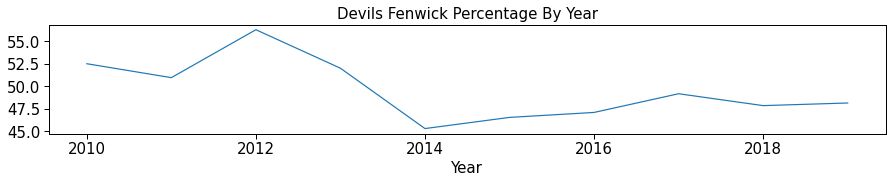

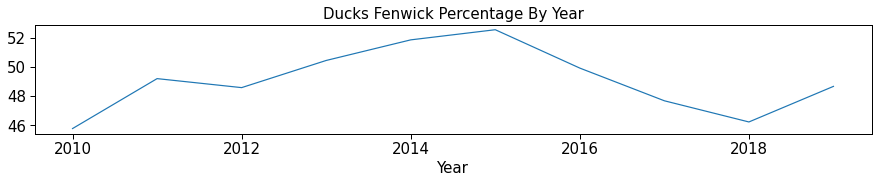

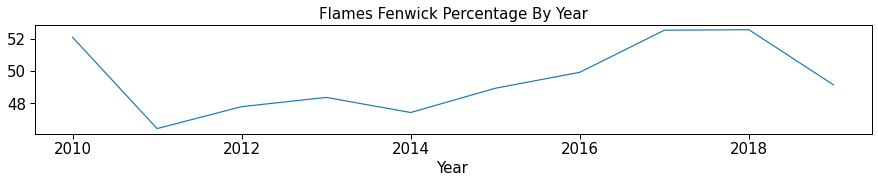

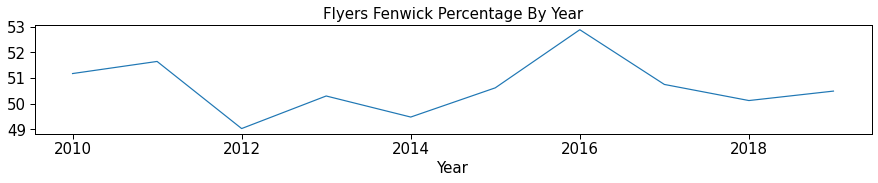

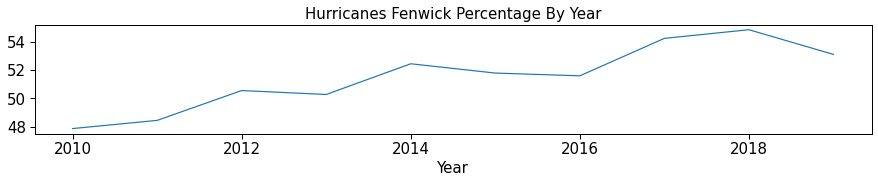

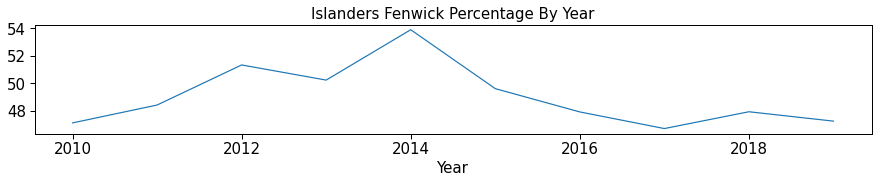

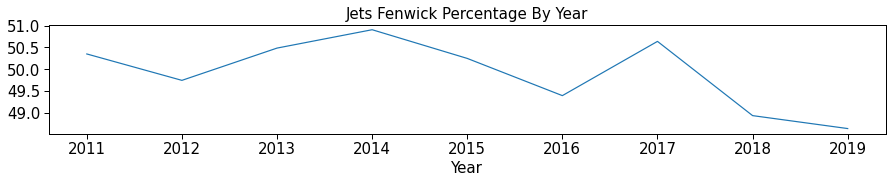

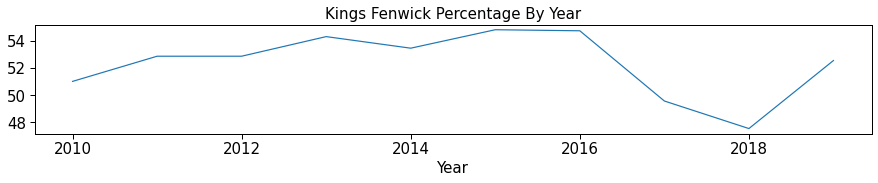

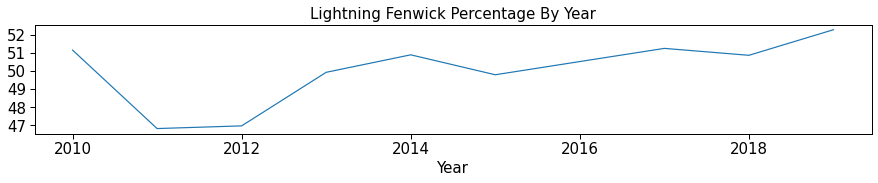

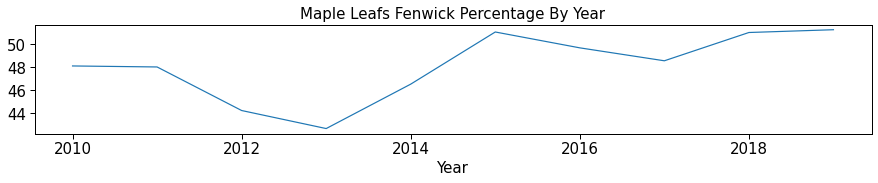

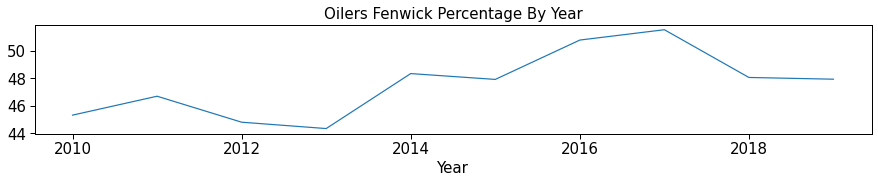

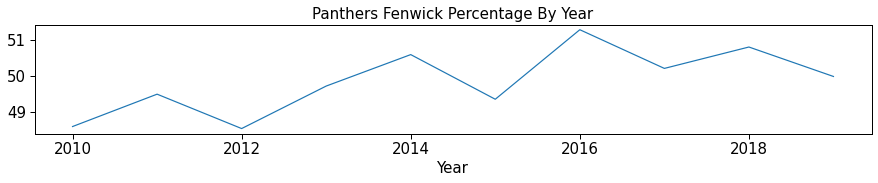

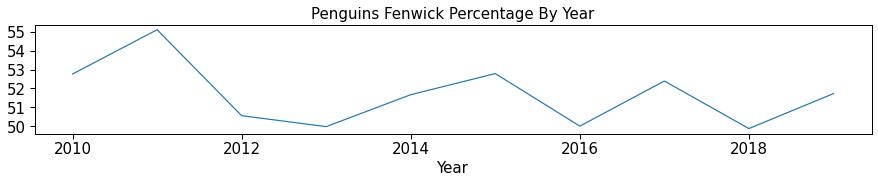

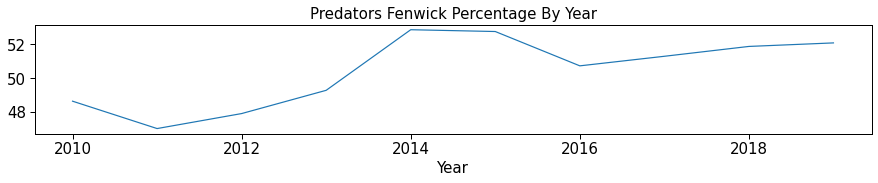

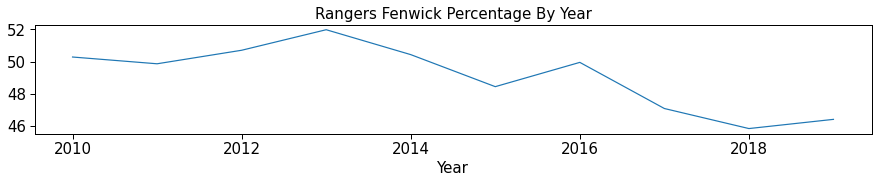

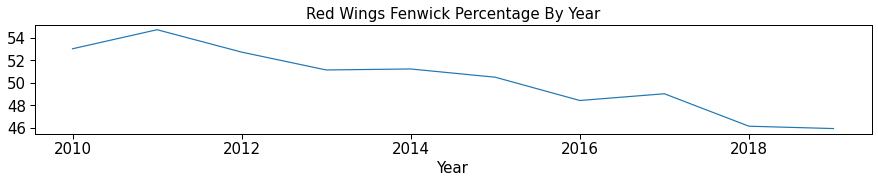

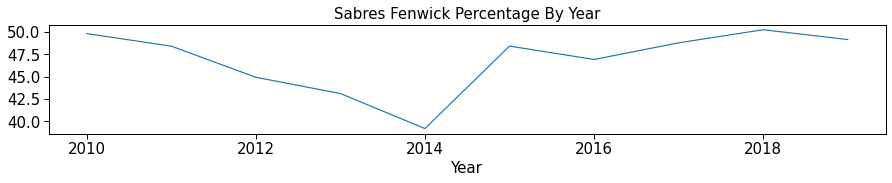

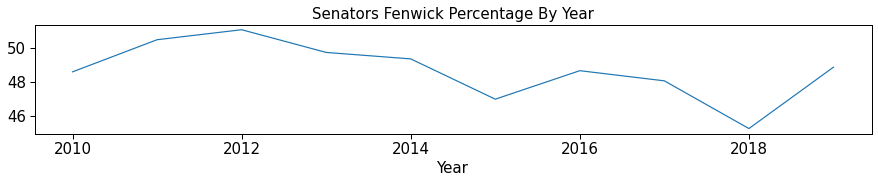

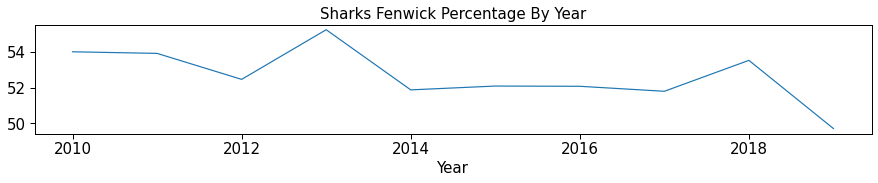

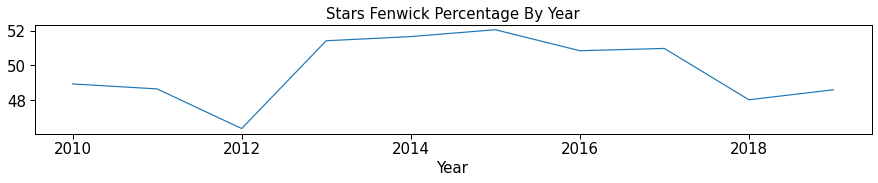

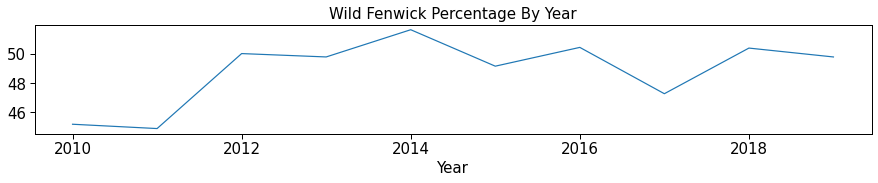

In [58]:
#NHL teams's fenwick percentage from 2010-2019
#fenwick excludes blocked shots

for team,data in adv_stats_df.groupby('teamName_cur'):
    data.set_index('season')['fenwick_percentage'].plot(x='season', kind='line', figsize=(15,2))
    plt.title('{} Fenwick Percentage By Year'.format(team),fontsize=(15))
    plt.xlabel('Year',fontsize=15)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.show()

<AxesSubplot:xlabel='goals_for', ylabel='shot_attempts'>

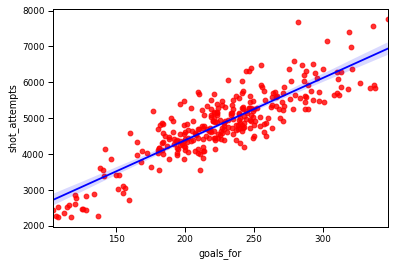

In [59]:
sns.regplot(x = 'goals_for', y = 'shot_attempts', data = adv_stats_df, scatter_kws = {'color': 'red'}, line_kws = {'color':'blue'})

### From a season-view, goals for and shot attempts are much more closely correlated to each other.

<AxesSubplot:xlabel='goals_for', ylabel='corsi_for'>

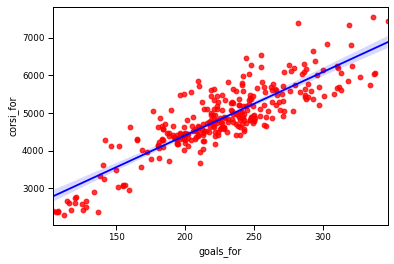

In [60]:
sns.regplot(x = 'goals_for', y = 'corsi_for', data = adv_stats_df, scatter_kws = {'color': 'red'}, line_kws = {'color':'blue'})

<AxesSubplot:xlabel='goals_against', ylabel='corsi_for'>

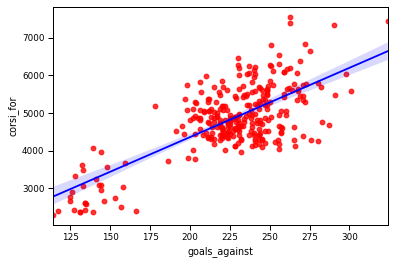

In [61]:
sns.regplot(x = 'goals_against', y = 'corsi_for', data = adv_stats_df, scatter_kws = {'color': 'red'}, line_kws = {'color':'blue'})

<AxesSubplot:xlabel='goals_for', ylabel='fenwick_for'>

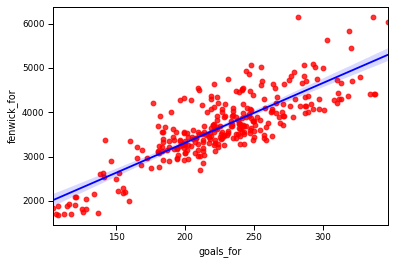

In [62]:
sns.regplot(x = 'goals_for', y = 'fenwick_for', data = adv_stats_df, scatter_kws = {'color': 'red'}, line_kws = {'color':'blue'})

<AxesSubplot:xlabel='goals_against', ylabel='fenwick_for'>

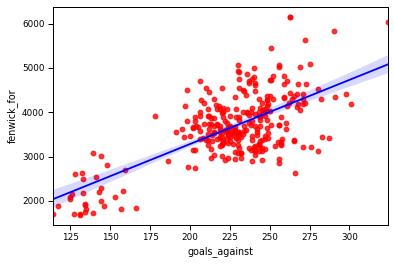

In [63]:
sns.regplot(x = 'goals_against', y = 'fenwick_for', data = adv_stats_df, scatter_kws = {'color': 'red'}, line_kws = {'color':'blue'})

Text(113.7, 0.5, 'Stat Features')

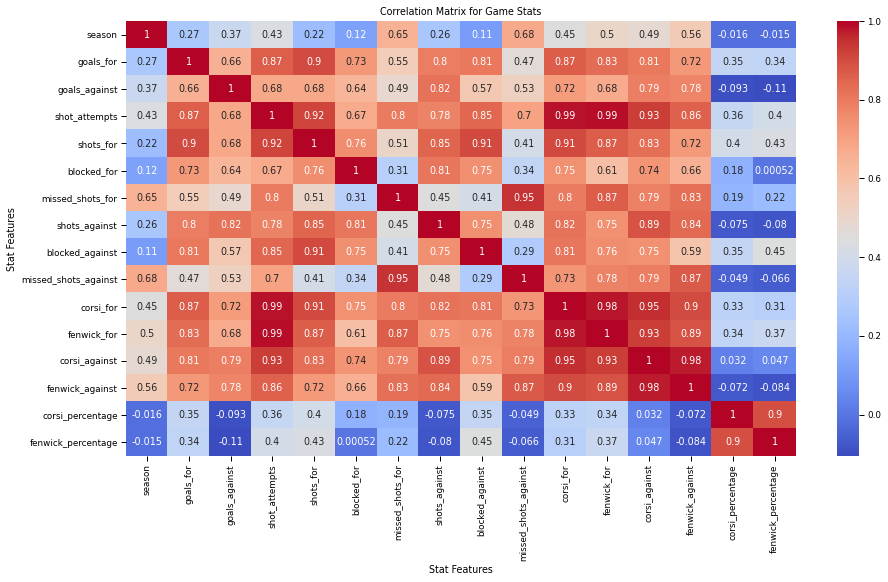

In [164]:
sns.set_context('paper',font_scale=1)
plt.figure(figsize = (15,8))
sns.heatmap(adv_stats_df.corr('pearson'), annot = True,  cmap = 'coolwarm')
plt.title('Correlation Matrix for Game Stats')
plt.xlabel('Stat Features')
plt.ylabel('Stat Features')